In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
from scipy.stats import zscore
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import OneHotEncoder
from scipy.special import logit, expit
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm 
import pybedtools
from pybedtools import BedTool

In [2]:
import gseapy as gp
from gseapy import barplot, dotplot

genes_df = pd.read_csv('../data/all_genes.protein_coding.bed.gz', sep='\t', 
                       names = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand'])


In [3]:
braaksc_pvals = pd.read_csv('../code/alzheimer_tables/Braaksc_linear_regression_pvals.tab.gz', sep='\t', index_col = 0)
braaksc_beta = pd.read_csv('../code/alzheimer_tables/Braaksc_linear_regression_beta.tab.gz', sep='\t', index_col = 0)
braaksc_zscore = pd.read_csv('../code/alzheimer_tables/Braaksc_linear_regression_zscore.tab.gz', sep='\t', index_col = 0)

ad_pvals = pd.read_csv('../code/alzheimer_tables/AD_logistic_regression_pvals.tab.gz', sep='\t', index_col = 0)
ad_beta = pd.read_csv('../code/alzheimer_tables/AD_logistic_regression_beta.tab.gz', sep='\t', index_col = 0)
ad_zscore = pd.read_csv('../code/alzheimer_tables/AD_logistic_regression_zscore.tab.gz', sep='\t', index_col = 0)

In [4]:
scrambled_ad_pvals = pd.read_csv('../code/alzheimer_tables/scrambled.AD_logistic_regression_pvals.tab.gz', sep='\t', index_col = 0)


In [5]:
EL = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf5_EL.tab.gz', sep='\t', index_col=3)
annot = pd.read_csv('../code/ebpmf_models/gao_models/tables/annotated.snmf_5.tab.gz', sep='\t',
                   names = [])
second_annot = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_annotation.snmf_5.merged_isoforms.tab.gz', sep='\t',
                          names = ['gene_id', 'transcript_id', 'chain_annot', 'annot_transcript', 'intron_retention', 'utr'])
isoforms = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf_5.merged_isoforms.exons.sorted.bed.gz', sep='\t',
                      names = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand', 'factor', 'exon'])

gencode = pd.read_csv('../code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz', sep='\t', 
                     names = ['chrom', 'start', 'end', 'gene', 'transcript', 'strand', 'exon', 'score', 'gencode_annot', 
                              'ensembl', 'mane', 'appris', 'annotation'])

beta_cols = [f'beta.{factor}' for factor in ad_beta.columns]
ad_beta.columns = beta_cols

In [6]:
ad_boxplot = pd.read_csv('../code/intron_retention.AD_dataframe.tab.gz', sep='\t')


In [7]:
ad_second_boxplot = pd.read_csv('../code/intron_retention.second_AD_dataframe.tab.gz', sep='\t')

In [8]:
len(pd.Index(ad_second_boxplot.gene.unique()))

838

In [9]:
len(pd.Index(ad_boxplot.gene.unique()))

1972

In [10]:
1972 + 838

2810

In [11]:
np.mean(ad_boxplot.groupby('gene').ad_beta.mean() >= 0)

0.8788032454361054

In [12]:
np.mean(ad_second_boxplot.groupby('gene').ad_beta.mean() >= 0)

0.905727923627685

In [13]:
factor_cols = ['factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5']

In [14]:
braaksc_pvals['FDR'] = fdrcorrection(np.array(braaksc_pvals.ACAT_pval))[1]
ad_pvals['FDR'] = fdrcorrection(np.array(ad_pvals.ACAT_pval))[1]

In [15]:
ad_pvals_beta = ad_pvals.merge(ad_beta, right_index=True, left_index=True)

In [16]:
IR_genes = pd.Index(ad_boxplot.gene.unique())#.union(pd.Index(ad_second_boxplot.gene.unique()))
ad_pvals_beta_sig = ad_pvals_beta.loc[ad_pvals_beta.FDR <= 0.05]

In [17]:
ad_pvals_beta_nosig = ad_pvals_beta.loc[ad_pvals_beta.FDR > 0.05]

In [18]:
beta_list_all = []
for gene, row in tqdm(ad_pvals_beta.loc[ad_pvals_beta.index].iterrows(), leave=True, position=0):
    arg_row = row.loc[factor_cols].argmin()
    beta_ = row.loc[beta_cols].iloc[arg_row]
    beta_list_all.append(beta_)

15232it [00:10, 1386.05it/s]


In [19]:
beta_list_no_ir = []
for gene, row in tqdm(ad_pvals_beta_sig.loc[ad_pvals_beta_sig.index.difference(pd.Index(IR_genes))].iterrows(), leave=True, position=0):
    arg_row = row.loc[factor_cols].argmin()
    beta_ = row.loc[beta_cols].iloc[arg_row]
    beta_list_no_ir.append(beta_)

2971it [00:02, 1338.53it/s]


In [20]:
ad_boxplot_all = pd.concat((ad_boxplot, ad_second_boxplot), axis=0).reset_index(drop=True)
ad_boxplot_genes = ad_boxplot_all.groupby('gene')[['ad_beta', 'zscore']].mean()

In [21]:
ad_boxplot_genes

,ad_beta,zscore
gene,,
ENSG00000000419,1.312211,1.298158
ENSG00000000460,-1.875295,-3.663856
ENSG00000001497,4.424001,4.339916
ENSG00000002746,1.856362,1.840059
ENSG00000002822,-1.520362,-2.427151
...,...,...
ENSG00000290203,0.803317,2.398823
ENSG00000290230,3.448981,2.979359
ENSG00000290263,1.402981,2.213381


In [22]:
beta_list_ir = []
for gene, row in tqdm(ad_pvals_beta_sig.loc[ad_pvals_beta_sig.index.intersection(pd.Index(IR_genes))].iterrows(), leave=True, position=0):
    arg_row = row.loc[factor_cols].argmin()
    beta_ = row.loc[beta_cols].iloc[arg_row]
    beta_list_ir.append(beta_)

# beta_list_ir = []
# for gene, row in tqdm(ad_boxplot_genes.iterrows(), leave=True, position=0):
#     beta_ = row.loc['ad_beta']
#     beta_list_ir.append(beta_)

1972it [00:01, 1378.13it/s]


In [23]:
beta_list_ir

[-1.1468917047033862,
 2.3355299638191416,
 1.5900248180524237,
 -2.557261038338021,
 2.9749484295452264,
 -2.9732558028336933,
 1.2345362997330644,
 6.15817873035448,
 1.0960195382420497,
 2.8338354800589487,
 2.3130170497938445,
 2.32420333855954,
 -2.449923224552931,
 1.118023630784448,
 1.4177318101724168,
 1.964416381181263,
 1.000961613227532,
 -1.718462771999575,
 2.1425775211421416,
 1.1622121475132223,
 1.5174238769199675,
 1.4160630966924337,
 4.863518528938882,
 3.514074232046552,
 1.26911689097795,
 3.5171027237491166,
 -1.7851992705012192,
 1.4239592270613046,
 -1.6836520464537068,
 2.236042171819348,
 1.1119580877640505,
 1.5748907048562224,
 1.9463434800127668,
 2.288806632215873,
 3.2726648556965534,
 1.4929468464824531,
 2.6703783402073697,
 2.4779575432770486,
 -1.365226778970694,
 1.84112080374146,
 1.92938255229268,
 2.391897861259232,
 1.7950703378043096,
 2.7930438357485667,
 2.806716089922171,
 1.3755181168596802,
 2.560315081705073,
 1.7399015127363768,
 1.61233

In [24]:
beta_df = pd.DataFrame()
beta_df['beta'] = beta_list_no_ir + beta_list_ir
beta_df['label'] = ['other']*len(beta_list_no_ir) + ['intron retention']*len(beta_list_ir)

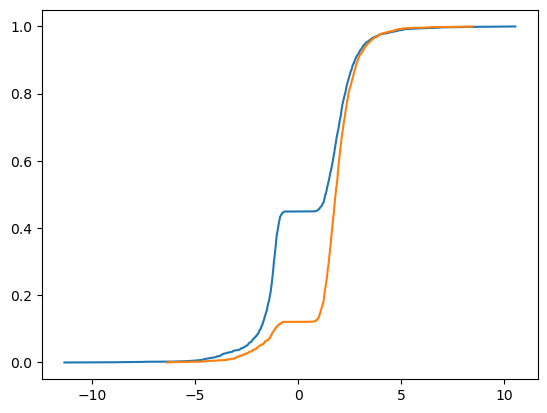

In [25]:
plt.plot(sorted(beta_list_no_ir), np.arange(len(beta_list_no_ir))/len(beta_list_no_ir))
plt.plot(sorted(beta_list_ir), np.arange(len(beta_list_ir))/len(beta_list_ir))

In [26]:
np.mean(np.array(beta_list_no_ir) >= 0)

0.5506563446650959

In [27]:
beta_list = []
pval_list = []
for gene, row in tqdm(ad_pvals_beta.iterrows(), leave=True, position=0):
    arg_row = row.loc[factor_cols].argmin()
    beta_ = row.loc[beta_cols].iloc[arg_row]
    pval = row.loc['ACAT_pval']
    beta_list.append(beta_)
    pval_list.append(pval)

15232it [00:11, 1346.05it/s]


In [28]:
ir_beta_list = []
ir_pval_list = []

for gene, row in tqdm(ad_pvals_beta_sig.loc[ad_pvals_beta_sig.index.intersection(pd.Index(IR_genes))].iterrows(), leave=True, position=0):
    arg_row = row.loc[factor_cols].argmin()
    beta_ = row.loc[beta_cols].iloc[arg_row]
    ir_beta_list.append(beta_)
    pval = row.loc['ACAT_pval']
    ir_pval_list.append(pval)

1972it [00:01, 1322.91it/s]


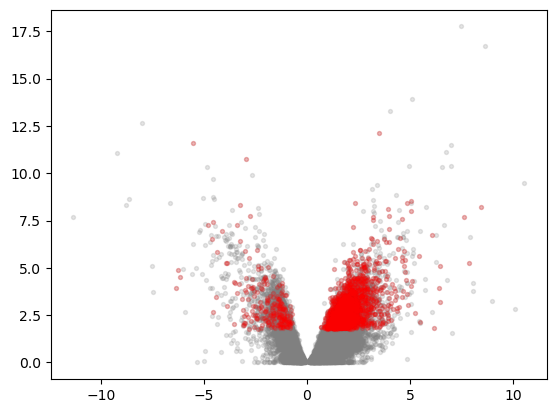

In [29]:
plt.scatter(beta_list, -np.log10(np.array(pval_list)), s = 8, alpha=0.2, c='gray')
plt.scatter(ir_beta_list, -np.log10(np.array(ir_pval_list)), s = 8, alpha=0.2, c='red')

In [30]:
positive_sig_ir = np.mean(np.array(ir_beta_list) >= 0)
positive_sig_no_ir = np.mean(np.array(beta_list_no_ir) >= 0)
positive_all = np.mean(np.array(beta_list_all) >= 0)

In [31]:
from scipy.stats import hypergeom

In [32]:
total_pos = np.sum(np.array(beta_list_all) > 0)
total_genes = len(beta_list_all)
ir_pos = np.sum(np.array(ir_beta_list) >= 0)
total_ir = len(np.array(ir_beta_list))

no_ir_pos = np.sum(np.array(beta_list_no_ir) >= 0)
total_no_ir = len(np.array(beta_list_no_ir))

In [33]:
hypergeom.sf(ir_pos, total_genes, total_pos, total_ir)

1.5066127419338232e-124

In [34]:
hypergeom.cdf(no_ir_pos, total_genes, total_pos, total_no_ir)

1.3080324549950693e-43

In [35]:
from scipy.stats import chi2_contingency
table = np.array([[ir_pos, no_ir_pos], [total_ir, total_no_ir]])
res = chi2_contingency(table)
res.statistic
res.pvalue

3.259671963258663e-25

In [36]:
total_no_ir/2

1485.5

In [37]:
table = np.array([[1485, no_ir_pos], [total_no_ir, total_no_ir]])
res = chi2_contingency(table)
res.statistic
res.pvalue

0.030252862027049292

In [38]:
table = np.array([[ir_pos, total_pos], [total_ir, total_genes]])
res = chi2_contingency(table)
res.statistic
res.pvalue

5.546874071148129e-16

In [39]:
from scipy.stats import chi2_contingency
table = np.array([[ir_pos, total_pos], [total_ir, total_genes]])
res = chi2_contingency(table)
res.statistic
res.pvalue

5.546874071148129e-16

In [40]:
total_genes

15232

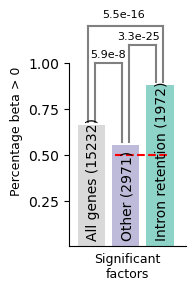

In [357]:
fig, ax = plt.subplots(figsize=(1.5, 3))
plt.bar(range(3), [positive_all, positive_sig_no_ir, positive_sig_ir], color=['#d9d9d9','#bebada', 
                                                                              # '#d9d9d9', 
                                                                              '#8dd3c7'])

plt.plot([-0.1, -0.1], [positive_all+0.02, 1.2], c='gray')
plt.plot([-0.1, 2.1], [1.2, 1.2], c='gray')
plt.plot([2.1, 2.1], [1.2, positive_sig_ir+0.02], c='gray')

plt.plot([0.1, 0.1], [positive_all+0.02, 1], c='gray')
plt.plot([0.1, 0.9], [1, 1], c='gray')
plt.plot([0.9, 0.9], [1, positive_sig_no_ir+0.02], c='gray')
plt.plot([1.1, 1.1], [positive_sig_no_ir+0.02, 1.1], c='gray')
plt.plot([1.1, 1.9], [1.1, 1.1], c='gray')
plt.plot([1.9, 1.9], [1.1, positive_sig_ir+0.02], c='gray')

plt.text(0.75, 1.13, '3.3e-25', size=8)
plt.text(-0.05, 1.03, '5.9e-8', size=8)
plt.text(0.3, 1.25, '5.5e-16', size=8)
ax.spines[['top', 'right']].set_visible(False)

plt.plot([0.7, 2.3], [0.5, 0.5], 'r--')
ax.set_xlim((-0.65, 2.75))
ax.set_ylabel('Percentage beta > 0', size=9)
ax.set_xticks([])
ax.set_xlabel('Significant\nfactors', size=9)
ax.text(-0.15, 0.05, 'All genes (15232)', rotation=90)

ax.text(0.85, 0.05, 'Other (2971)', rotation=90)
ax.set_yticks([0.25, 0.5, 0.75, 1])
ax.text(1.85, 0.05, 'Intron retention (1972)', rotation=90)
ax.spines['left'].set_bounds(0, 1)


# plt.savefig('../code/scratch_figures/figure5/beta_direction_more.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure5/beta_direction_more.png', bbox_inches='tight', dpi=500)

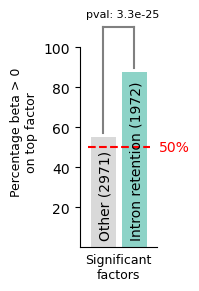

In [336]:
fig, ax = plt.subplots(figsize=(1, 3))
plt.bar(range(1, 3), [ positive_sig_no_ir, positive_sig_ir], color=['#d9d9d9','#8dd3c7', 
                                                                              # '#d9d9d9', 
                                                                              '#8dd3c7'])


plt.plot([1, 1], [positive_sig_no_ir+0.02, 1.1], c='gray')
plt.plot([1, 2], [1.1, 1.1], c='gray')
plt.plot([2, 2], [1.1, positive_sig_ir+0.02], c='gray')

plt.text(0.45, 1.15, 'pval: 3.3e-25', size=8)
ax.spines[['top', 'right']].set_visible(False)

plt.plot([0.5, 2.5], [0.5, 0.5], 'r--')
plt.text(2.8, 0.48, '50%', c='red')
ax.set_xlim((0.25, 2.75))
ax.set_ylabel('Percentage beta > 0\non top factor', size=9)
ax.set_xticks([])
ax.set_xlabel('Significant\nfactors', size=9)
ax.text(0.85, 0.05, 'Other (2971)', rotation=90)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['20', '40', '60', '80', '100'])
ax.text(1.85, 0.05, 'Intron retention (1972)', rotation=90)
ax.spines['left'].set_bounds(0, 1)

plt.savefig('../code/scratch_figures/figure5/beta_direction.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/beta_direction.png', bbox_inches='tight', dpi=500)

In [359]:
c2_dict = {}
with open('../code/c2.ALZHEIMER.gmt', 'r') as fh:
    for line in fh:
        row = line.rstrip().split('\t')
        tag = row[0]
        genes = sorted(row[2:])
        if 'PKFP' in genes:
            print(tag)
        c2_dict.update({tag:genes})

In [48]:
ad_ctx_genes = 'AQP1/ZNF366/VANGL1/OSMR/CACHD1/CLIC4/LPP/TRIM14/MDFIC/KDM1B/PAPOLA/RNF144B/FAM129A/SLC7A2/PPP1R3C/CP/GAS2L1/GIMAP1/MRVI1/TBL1X/IL4R/CD302/SYNM/MYO10/BIRC3/AMOT/P2RY2/ATP1A2/STAT3/ABHD15/ITPR2/WEE1/INHBB/PHKA1/DKK3/ITPKB/PERP/CDH5/FGFR1/ARHGEF26/MTSS1L/RASSF8/SLC7A11/GPR4/ARL6IP6/FREM2/ZIC3/PLEC/LRP1B/GRAMD1C/SRGAP1/ID4/MAPRE1/VSTM4/RRAS/PLXNB1/HIST1H2AC/CR1/ANGPT2/LATS2/BMPR1B/CLDN5/SOX6/PLIN2/UHRF1/DLC1/CBX2/FOXO1/P2RY14/CDH20/LAMC1/SOX2/EMCN/GRTP1/OMD/CERS1/TIMP3/RANBP3L/SLC25A20/TMBIM1/KCNN3/ARHGAP42/ERBB2/DTNA/ENG/ADH1B/TLCD2/GPRC5B/SNX7/FAM167B/LONRF3/EMP2/LEPR/HERC2P3/CTGF/PALLD/CFH/CD81/CHST3/IGSF11/GNG5/PDGFC/MTM1/SMAD9/SULT1C4/PTBP1/TMED10/GPR146/FZD1/ADAM12/C2orf40/RYR3/EGFR/PGM2/SLC1A3/IL17RB/TBX2/FLT4/CD59/KCTD12/PRKG1/PGF/HEYL/SHE/SLC39A11/CHDH/MYO1C/MT3/SLC9A9/BCL2/CASZ1/TLN1/AHCYL2/IFITM3/PARP14/PRDM5/SPON1/LPIN3/ADRB2/KLF6/ABHD4/FAM84B/HRH1/MID1IP1/PLIN1/PPP1R13L/ANPEP/TMED5/TPD52L1/SDC4/PDE4B/PDLIM5/SOX9/IL18R1/ITGB1/PTPN13/ZIC1/GJB2/AZGP1/SOX17/TRIP6/SUN2/FGD6/ZBTB33/KCNE3/ITPR3/ABCA1/ITGAV/ZIC5/DCAF12/PITPNC1/UNG/TLE1/NHSL1/GNA12/GPT2/SEC14L1/ACVRL1/ZC3H12C/FKBP5/TRAM1/SNX33/RHOJ/FGD5/CD109/RAB23/BCAR3/KIF26A/TBX3/ERLIN2/ALDH1L1/ABCG2/LPAR3/MKLN1/FAM107A/ADCY2/SLC2A4/FAT4/ABCC9/EDNRB/PREX1/STARD8/ST6GALNAC3/SALL1/NBPF10/GABRG1/STK32A/PLSCR4/MFHAS1/MATN3/FAT1/TRPM3/MKNK2/HHEX/DDR2/ALPL/GPC5/NOTCH4/LAMA5/PBXIP1/IGFBP7/SP1/ZNRF3/CLEC14A/HEPH/S100A8/CYBRD1/CGNL1/PODN/PTH1R/GPR75/GNA13/FZD9/DGKG/CDC42EP4/CD34/FLNA/KRT19/ACSBG1/ZNF516/PLEKHA7/PIK3CA/NOTCH2/IRAK3/CTDSPL/NTRK2/GYG1/TLR4/HEG1/AHCYL1/CALCRL/LGR4/MYBPC1/EHHADH/MAGT1/USP53/SLC19A3/ZC3HAV1/NID1/ZBED6/VEZF1/RAB31/EMX2OS/CPNE3/FERMT2/ITGA6/LEF1/SH3GLB1/CTDSP2/MGST1/LRP5/PRKD3/RREB1/APPL2/YES1/CREB3L2/KANK3/LIX1L/PAPLN/METTL7A/CYYR1/ABLIM1/FYCO1/GMNN/ATP13A4/B3GAT2/LRRC8A/PRDM16/ARHGAP29/ACSS3/CDC14A/MERTK/S100A9/TMEM204/GPAM/KDELC2/PON2/FUT9/SOD3/GJA1/SOX5/TEP1/SFT2D2/PAPSS2/RBMS2/SALL3/ECE1/CLEC4E/HSDL2/PODXL/PRKCA/PEX11A/TP53BP2/FAM198B/STOM/SMAD6/SLC2A1/HEPACAM/PEAR1/GJB6/STAG2/ADD3/IMPA2/ELOVL7/CALD1/CPT1A/KLF3/EPHX1/TIE1/NOTCH3/UTRN/QKI/TMOD3/ACSL5/SASH1/AQP9/DOCK6/GPRC5C/GPM6B/CDA/MLEC/REST/ATOH8/OPHN1/SMAD5/ITGB4/PLIN3/EDA/TAB2/MR1/NACC2/EPHB4/CRYBG3/GLI3/APCDD1/KIF5B/ASPH/YAP1/NQO1/PTAR1/AK3/AKAP13/KLF15/ARHGAP5/GGT5/TGFBR3/HIF3A/TRPS1/PTPRB/ADIPOR2/FIGN/MFAP3/ARHGAP31/LIFR/TCF12/SLC40A1/MECOM/MEGF10/SLC30A1/HVCN1/DAG1/PRKX/GATA2/PLEKHG1/ZNF81/ROCK1/RHOBTB3/ARAP2/AFF1/SAMHD1/TINAGL1/RXRA/FAM129B/DCHS1/TBC1D14/BCAM/EPS8/MAOA/HMBOX1/TXNIP/TEAD1/PPARA/THSD4/LRP10/OGFRL1/GABRB1/ITGB8/PARD3/TMTC1/HEATR5A/VWF/ATP10A/ITGA1/LRP4/AHNAK/PDK4/EIF4EBP2/IKZF2/FNDC3B/ZIC2/SLC14A1/HSPG2/KANK1/ZFHX3/TNS1/PREX2/EPAS1/WASF2/NEO1'
ad_ctx_genes += '/GAP43/CALN1/TRPC1/KCNAB1/NELL1/SLC6A17/DOC2A/GPR158/CNGB1/ITFG1/PPEF1/MSC/GNB5/RBM26-AS1/VGF/CAMK1D/CDH18/KSR2/HTR7P1/EFR3B/YWHAG/CCDC144A/TSNAX/A1BG/RASGRF2/RPH3A/PHF7/TOMM20/SYCE1/NRN1/RNF165/ACSL4/SPHKAP/FRMPD2/HECW1/DNAJC6/GPRASP2/DMXL2/TNFRSF11A/SLITRK3/STMN2/GNG4/ORC6/EPHA4/SPNS1/KIF17/KLHL35/ZNF169/BAIAP2L2/DPY19L2P2/ACADSB/NTSR1/STOX2/GPR137C/SCN8A/MPO/ATOH7/CNTNAP5/MPPED2/PRKCE/COL9A3/MAP3K9/FGF13/NEU3/NEGR1/GLRA2/ASPHD1/KIAA1324L/GRM7/KCNB2/NAPB/PPM1H/INSM1/SLX4/RTBDN/TRHDE/SYT1/EPHA5/TMEM169/RAB3B/KCNF1/DLEU2/ZNF418/COL19A1/OTOGL/EIF4E/GDAP1/KCNC2/UNC13A/ELAVL4/GOLT1A/SVOP/GREB1L/FAM102B/NOVA1/NMNAT2/OSBPL10/LINGO3/ST6GALNAC5/HDAC9/HES4/CACNA2D1/GABRA1/FRMPD4/SV2B/ZDHHC23/DNM3/SYCE1L/EID2B/NKAIN2/ERC2/DLGAP1/WNT7B/TDRKH/SLC30A3/ANKHD1/MFSD6/ZNF138/HTR2A/ICAM5/SLC16A8/LY86-AS1/IQGAP3/MYO16/CNR1/SUSD4/ZDBF2/CREB3L1/SLC4A10/KCNV1/NTN5/RAB3C/FBXW7/UNC5D/SVEP1/DLGAP2/GPR12/NUAK1/ANO3/RGS4/LONRF2/TMEM17/NPTXR/XKR4/SYN3/SCN2B/SLC22A18/PAK3/RGS7BP/PLCB1/ATP8A2/PMS2/SLC16A14/HBA2/RAB27B/CDT1/SCN2A/CENPF/DOCK3/CDH8/GDA/PPM1E/TBC1D9/GPRASP1/RNF150/SGIP1/CDKL5/LSM11/PAIP2B/RIMS1/GRM8/OLFM3/PEG3/PPP2R2C/RGS17/RPLP0P2/GAS7/FAM126B/SAMD14/CSRNP3/ENPP5/HBA1/HUNK/DGKI/CECR2/G3BP2/MEIS3/IPCEF1/HECW2/PCLO/CREG2/SAMD12/TET1/TRIM36/DCAF16/PART1'
ad_ctx_genes += '/NOS3/PAPLN/PRRX1/COL4A4/ITGA5/C1QC/ELOVL7/IKZF2/TBX2/MT2A/CALD1/CD34/SDF2L1/LAPTM4A/EPHA2/ITPKC/VSIG4/TCN2/AQP9/C4B/HLA-B/LYN/EMILIN2/KCNJ5/ST5/OTX1/RNF144B/ACTL6A/TNS1/IL13RA1/STK38/LAMP2/RNASE6/SIGLEC9/APOL4/DCHS1/TNFAIP8/FAH/PLSCR1/SLC39A11/MKNK2/HLA-C/IL6R/ALOX5AP/SLC7A2/FOXF1/HEPACAM/RHPN2/GPM6B/CPNE3/APOE/INPP5D/HSD3B7/ADAMTS7/MYCT1/PDLIM4/ATP1B2/LRRC3/SLC30A1/DAD1/MMP14/CD93/RFX4/CEBPD/WFIKKN2/NOTCH4/PCOLCE2/NLRC5/SERPINE1/LRP4/SLC9A3R1/PCDHGB6/EHD4/GPNMB/EPHB4/ECE1/PARP10/PTH1R/NMB/GIMAP2/PON2/MLKL/PTP4A3/NXN/ATOH8/RELL1/TRIM47/VCL/SCIN/GSN/TEP1/CERS1/SDC4/RAB34/VASN/GABRE/CMAHP/IFI16/PTCHD1/SRGN/CLEC2B/TP53BP2/RDH10/P2RY2/ADORA2B/MAOB/SLC14A1/QKI/CAT/ZNF366/TNFRSF12A/FGF2/HEPH/EHHADH/GABRB1/LIX1L/TSPO/ZDHHC2/NPC2/CR1/VWF/CLEC18B/TNFRSF1A/MPZL1/ITPR3/CLDN5/SUCLG2/EMP3/KLF6/REST/IFI44/CD163/MAP3K8/ZIC2/MFAP3L/ZFP36/PARP14/SHISA3/PCDHGB1/CDH5/S100A11/TAB2/WWTR1/LIMS1/IRAK3/TXNIP/ATP10A/PGF/LPP/MTM1/KDELC2/SOCS3/DDX60/GPR4/C1QTNF1/MMRN1/NAGS/TRIM5/XBP1/TMEM45A/SULT1C4/MECOM/RAB13/EPHX1/HGF/PLOD2/EIF4EBP1/MT1X/PKN3/ADAM12/MANEA/TRPC4/PTAR1/SHE/RARRES3/SLC9A9/MR1/DNAJC1/SERTAD1/ITGA7/FGFR1/P4HA1/PREX2/IMPA2/NMI/TMED5/MTHFD2/HSPB1/CLIC1/TNFRSF1B/APOL6/STK40/CBX2/IQGAP1/SOAT1/RGL3/RAB27A/BCL6/BTG2/ITGA10/LIMK2/FKBP10/ITPRIP/MT3/ORAI1/TCP11L2/MSN/PLEKHG2/HSPG2/ARHGEF10/COL4A1/BGN/CD44/PCDHB7/C11orf96/EPAS1/DOCK6/IFI35/HIST1H2AC/IFITM1/ABHD4/PCDHGA11/PMP2/SLC2A1/STAB1/GJA4/SPP1/PDK4/IL4R/CASZ1/CHI3L2/PALLD/PIM3/ZIC1/LHFPL1/VWA5A/FAM84B/IRF1/HK3/ITGB1/MATN3/TMED10/NAMPT/FNDC3B/VAMP8/TIMELESS/TP53/APPL2/BAMBI/TNFRSF10D/ATP6V0E1/TIPARP/RAB32/MYD88/CCNG1/NID1/FPR1/SMAD6/PNP/IL18R1/SAMHD1/SLC22A3/BIRC3/ELF1/NFKB2/AXL/TEAD4/SLC7A7/ANXA5/PRICKLE3/SESN2/PODXL/ADH1B/WEE1/LRP10/PDIA6/CDKN1A/ELOVL5/AZGP1/NEK6/RAB20/GTF3C6/PARP9/SERPINA1/SOD3/SLC39A1/TGIF1/CNN3/CFH/ANXA2/PLEKHA4/TMEM176A/ARHGAP29/TFPI/RHOC/ADAMTS9/BATF2/MAP7D3/KANK3/PITPNC1/C1QB/BAG3/LGALS3/BAZ1A/PGM2/CRYAB/ARHGEF19/SERPINH1/CYP4F11/IFITM2/MAPKAPK2/CLEC4E/GBP1/IGFBP7/PEAR1/SLC19A3/IL1R1/ELF4/ADAMTS1/TMEM176B/KIAA0040/ITGA1/PECAM1/S100A10/TBX3/ACSL5/ITGB4/TTC38/TUBB6/TAP1/PCDHGB7/ANGPT2/MCL1/IRAK2/ICAM1/OSMR/HMOX1/DNAH11/SLC2A4/AHCYL1/HAP1/TUBA1C/GGT5/PRKX/SH3BP2/HIST1H2BK/GMNN/LAP3/STOM/FLNA/AK3/GBP2/CDK2/SLC44A3/SFT2D2/DTX3L/PTBP1/TAGLN2/C1R/MAFF/CHST3/PLIN3/CP/ADIPOR2/PLP2/FERMT3/HEYL/NQO1/S100A9/PYGL/S100A16/TIMP1/C1S/EMP1/MAGT1/VAMP5/BST2/LAMA5/TNFAIP3/S100A8/WASF2/FERMT2/RELA/ROM1/NUAK2/THSD4/SMAD1/PDE4B/ANGPTL4/PLIN2/PYCR1/CHSY1/FAS/CHI3L1/CREB3L2/NGFR/SERPINA5/TCIRG1/DYNLT1/CD55/CAV1/MGST1/CLIC4/ALDH1L1/TMBIM1/GNG5/IFITM3/ZC3HAV1/SERPINB1'
ad_ctx_genes += '/HBA2/PKMYT1/CAMK4/ACADSB/ESR1/PCLO/SUB1/NRG4/SCN3B/TECTA/PLAGL1/DHDH/REM2/TOX3/KCNS2/SFTPA2/MADCAM1/TMEM151B/CHRM3/LINGO3/SYCE1L/ICOSLG/RASAL1/GRM8/AKAP5/PTPRR/PRKCE/UQCRHL/PPP2R2C/NEUROD6/HECW1/HTR2A/L3MBTL1/ASB2/PPM1E/UBE2V2/MLLT11/MTF2/NECAB2/PHF7/ELMOD1/FANCA/GALNTL6/C1QTNF4/JAZF1/CHCHD7/ADRA1D/GSTO2/GRIN2B/CCDC122/RGS17/BEX1/NUAK1/HAS1/CLDN4/WDR66/RIMBP2/YPEL4/SUSD4/GABPB1/PTRH1/CRYM/GRIPAP1/PRKCD/FGFBP3/SPNS1/CENPE/C9orf139/SLC16A6/CLUL1/CRIPAK/WNT11/ACP2/LIAS/WASH5P/PPP1R3E/EFR3B/SRSF12/ANKRD36/PNCK/PPEF1/CACNG8/KCNB2/TBC1D9/CECR2/C17orf102/PIWIL2/HBA1/ORC6/SPATA7/HAR1A/GABRD/RGS7/PARM1/GLYCTK/MPPED2/GRM7/GAD1/PRRG3/NTSR1/FBLN7/NKD2/NRXN3/GREM2/GRB7/CHAF1A/DNM3/HDAC9/FTCD/G3BP2/C5orf34/ATOH7/ITGA2B/DOC2A/ADSSL1/VWA5B2/STAG3L3/CRHBP/A1BG/SCG2/SYT1/SLC22A18/SGIP1/GOLGA8A/HOOK1/PCDHA1/CES3/GPRASP1/ZBBX/CFP/TSNAX/FAM126B/LY86-AS1/RPH3A/SPON2/CCKBR/VWC2/FAM81A/PIGL/PAAF1/ZDBF2/TLE6/ENPP5/STAG3L2/CGREF1/PCDHGC4/LCN15/ZCCHC12/NCALD/PGM2L1/MYL5/EXOC3L1/DLGAP2/ZNF449/ZNF418/SLC4A10/ASPHD1/PCYOX1L/EIF4E/DTD1/GABRA3/TRAPPC2L/SST/DBIL5P/ERC2/SORCS3/SAMD14/GLDN/NMNAT2/TAF1D/LGI2/PLAG1/USP44/TNNI3K/LYPD6B/MLIP/WNT10B/TMSB4X/OLFM3/FAM122C/SUGT1P3/SLC32A1/DRP2/BRD9/DHRS11/CES2/KCNG2/MAGEC3/RNF128/FGF13/ARHGAP20/PLK2/SYT5/ZNF226/GLRA2/ITFG1/PTPRO/PLK4/TRPV6/KEL/TMEFF2/ARSG/RBM3/DPP6/GAP43/TIMM23B/PDE10A/KCNV1/TCERG1L/CDH7/COL7A1/TACR2/ANKRD19P/GOLT1A/HECW2/UNC13A/INSM2/INSM1/LONRF2/DNAJC5G/KIAA1324L/TCHH/NRSN1/CHGB/PPP1R14C/PCSK1/RIMS1/TAC1/TMEM17/GPR68/PAK1/AP1S3/PCDHA7/GNG4/ARMCX4/C19orf48/DUSP4/PART1/FBXL22/BEND5/SLC22A9/NELL1/CIRBP/CES4A/CREG2/TYRP1/ACTA1/PMS2P4/GABRG2/RCAN3/ABCC12/SVOP/SLC6A17/ARL17B/SH2D5/FRMPD2/HMGB3/RAB3B/SPRED3/GDA/TRIM54/VGF/OTOGL/HACL1/ANKHD1/CREB3L1/IQGAP3/NPTXR/CCT6B/ICAM5/BAIAP2L2/RPLP0P2/NAPB/HSPB3/PRMT8/NRN1/RGS4/C17orf107/TET1/KCNF1/EID2B/MAL2/ALOXE3/HUNK/MEIS3/ADCYAP1/SLC30A3/RXFP1/DCAF16/MPO/ZDHHC23/DRD4/SLN/SLC16A8/BDNF/ELAVL4/DCST2/RRN3P1/HES4/'
ad_ctx_genes = sorted(set(ad_ctx_genes.split('/')))

ad_dlpc_genes = 'COL5A3/PFKP/ADAMTS2/S100A4/NRIP2/SPP1/SLC4A11/LSP1/RRAD/CXCR4/HSD11B2/EMP3/AQP6/CA2/NEFH/NPNT/NWD1/COL27A1/SLC5A11/QDPR/GIPR/SLC6A9/UGT8/SFRP2/PHYHD1/APLN/ISYNA1/FANCC/HSPA2/HIC1/CLCA4/MT1F'
ad_dlpc_genes += '/ADCYAP1/TRIM45/FREM3/CHML/PRSS35/HMGN2/PPEF1/VGF/PRTN3/ALDH1A1/FRMPD2/PALMD/MPO/PNMA5/ZNF334/MATN3/MDK/SLC30A3/IQGAP3/WDR86/PPDPF/MEIS3/TET1'
ad_dlpc_genes += '/NRIP2/ADAMTS2/PRELP/HSD11B2/ISYNA1/SFRP2/S100A4/FANCC/SLC4A11/NWD1/ST6GALNAC2/PHYHD1/SLC6A9/KCNJ10/ELK1/A2ML1/NEFH/HSPA2/CCDC69/PFKP/LSP1/COL27A1/KCNJ16/TMCC2/AQP6/ANLN/SLC5A11/MT1F/RBPMS2/FOXO4/CCDC102A/COL5A3/SPN/APLN'
ad_dlpc_genes += '/SLC16A6/PPEF1/C17orf102/SPDEF/ALOX12B/ZBBX/SPON2/TNFRSF18/PCYOX1L/SST/PNMA5/PRSS35/ZNF334/MATN3/ALDH1A1/SDSL/RBM3/PRTN3/WDR86/FRMPD2/VGF/MDK/IQGAP3/ANKRD30B/TET1/MEIS3/ADCYAP1/SLC30A3/MPO/HMGN2/BDNF'
ad_dlpc_genes = sorted(set(ad_dlpc_genes.split('/')))

ad_cbe_genes = 'OSMR/ZNF670/CLIC4/PANK1/SYT14/GLUD2/AOC2/SSTR2/AMIGO2/CP/SOS1-IT1/POLR2A/IL4R/FSTL5/RNF169/SLC12A2/BIRC3/PGM2L1/DDX21/KCNK2/PHF3/HSPA8/ARHGAP20/CLVS2/HECA/OPCML/SORT1/NOMO3/FBXO11/GPR4/TCAP/UPF2/MCM8/HIST1H2AC/ANGPT2/SMC4/LATS2/ECT2/RRAGD/FAN1/F2R/HSP90AB1/HSPA1L/REL/ZNF510/GAP43/CALN1/RANBP3L/KIAA1109/NELL1/ARHGAP42/CLPB/EDIL3/FAM167B/LONRF3/SMAP1/C1orf115/CTGF/CFH/PARVA/HIST2H2BF/GUSBP4/CHST3/CDH18/CCDC144A/RAP1GAP2/FUT10/HIST2H2BE/ERV3-1/ATF6/DNAJB4/MED1/LCA5/ACTR8/TBX2/ZNF550/SPHKAP/KCTD12/FRMPD2/DNAJC6/SH3BP5/SERINC1/SHPRH/OLFML2B/IFITM3/KCNH7/SPON1/ASAP2/ADRB2/KIF3C/HRH1/MID1IP1/UHRF1BP1L/DPY19L2P2/ANPEP/TMED5/OTUD1/ANKRD6/SYNE1/ENGASE/CNTNAP5/HYOU1/PRKCE/ZBTB33/KCNE3/ITPR3/GLRA2/PTPN4/APC/NFAT5/ACVRL1/KCND3/NAA35/CRISPLD2/FKBP5/FGD5/RAB23/MKLN1/EPHA5/DNAJA1/COL19A1/RASA1/PPP1R15B/ZBTB11/STARD8/LTN1/MAFG/HSPA13/RANBP6/PIK3CD/IGFBP7/CLEC14A/UBE4A/S100A8/SYTL5/ADCY7/PLCL2/ZNF845/SV2B/FLNA/NRIP1/PIK3CA/UNC13C/NPTX2/TMEM56/TLR4/RBM12B/ZNF138/DOK6/ZBED6/USP32/ZNF12/ZDBF2/ZNF721/RPL23AP7/TCF20/RAB3C/GALNT2/OXR1/NUAK1/IL1RAPL1/FILIP1L/ZNF420/LONRF2/NPTXR/S100A9/TXNRD1/GTF2I/FUT9/RBBP5/RGS7BP/KCNB1/TCP11L1/HTR1A/PURA/AKAP9/ZNF318/ZHX1/C1QL3/CRNKL1/SMAD6/GOLGB1/CNOT1/GNL3L/CENPF/PEAR1/CANT1/IMPA2/C9orf129/TBC1D9/ZRANB1/ACSL5/AKAP12/AQP9/WDR86/CDA/ZNF503/KLHL11/BMPR2/ATRX/EPHB4/CRYBG3/FBXL14/PTAR1/TRAPPC10/OLFM3/ALG11/TGFBR3/FAM169A/MFAP3/PPM1L/AIDA/ZNF808/ZNF354C/HSPA4/FOXO3B/INCENP/ZXDA/GTF3C4/PSAP/KLF11/ZNF483/KCNJ12/ZNF81/TINAGL1/TBC1D14/PDZD8/CCDC144B/CYP7B1/SLC2A12/EXOC8/DIXDC1/KLHL9/RNF111/GABRB1/TMTC1/KIF2A/TRIM23/SSTR1/TMCC1/HSPG2/SMCR8/ZBTB16/PLEKHM3'
ad_cbe_genes += '/CEP95/INO80C/THBS3/U2AF1/SNRNP35/LMF1/DPY19L2/NASP/CRYGS/KLKB1/CCDC57/IFT43/ZNF133/CCDC84/CDK5RAP3/OSGEP/COMMD3/AMY2B/TTC31/SPAG8/ABHD11/MSTO1/LUC7L/PCBP4/ADAMTS2/SLC38A6/OXA1L/CCDC58/SCNN1D/SCLT1/COL11A2/ENO3/COQ3/TTC21A/CRIP3/C1orf123/GPT/FER1L4/FUS/HKR1/THOC1/LPXN/AGAP6/IL11RA/TEKT3/LY6G5B/UPP1/ITPA/BEAN1/AMT/ZCWPW1/TNNI3K/CLEC2D/LRRC20/SLC35A1/SLC10A4/ZNF691/MYO19/MPV17/GSTA4/DGKA/COL28A1/RIN1/PIGZ/TPCN2/PMF1/WDR78/TRIM7/POLR3G/NME5/LAMA4/SH2D6/NSMAF/TRANK1/DNM1P35/PDZD7/DYNC2LI1/SEMA5B/QTRT1/PNMA3/MTBP/UBXN11/PDE7A/MYH3/TIMM9/IFT122/COQ4/EZH2/SNHG1/ADPGK/THPO/DPY19L2P1/TTC17/ADAMTS14/PLA2G5/WDR54/SLC25A29/NMRAL1/FCHSD1/GLYCTK/NIPAL4/USP43/KCNIP1/TARBP1/TRPT1/PMFBP1/ADCK1/FREM1/EGR4/DNAH2/CCS/LXN/ICA1/ANAPC7/CBY1/BZW2/LAMB1/CA3/N4BP2L1/CERCAM/LRRC37A3/MEI1/COMMD4/FBXO15/CARNS1/AK8/SYCP2L/EPN3/SRP19/TAF7L/LRRFIP2/RCOR2/DYNLRB2/NEAT1/TRMT11/CEP164/KIAA0895L/NT5M/ANKRD13A/MIAT/FAM76A/HGSNAT/C4orf33/CRIPAK/SLC25A13/CSDC2/ARTN/EXD3/FARSB/WSB1/PARP2/TMC7/CATSPER2/TDG/BTBD17/SAMD10/RNFT1/GSTZ1/C16orf74/ECHDC2/LINGO2/MORN3/SFI1/PLEKHH1/SCMH1/ALG6/RYR1/DBF4B/GOLGA8B/MED4/ABHD14B/KLHDC9/CKMT1B/CPNE6/PARD6B/BCL2L15/ZNF300/CTDSP1/PRCD/HR/C12orf45/EFNA5/KCNH8/HFM1/DCLK1/ABCA10/ZNF18/TMEM175/ANKDD1A/GLIPR2/SNX22/GRK4/RFESD/IFITM10/NEK3/METTL23/NRSN2/ST3GAL3/CLK4/ADSSL1/SCRT1/ACP2/MAGEL2/AGBL4/SLC38A7/GSS/SLC25A45/RASSF7/MAEL/FAM86B1/ALOX12P2/INHA/ELMO1/DCAF8/CBWD3/HPN/TMEM151A/STAC2'
ad_cbe_genes += '/CMTM1/CEBPD/CHST2/SERPINE1/ADRA1D/EPHB4/DOK6/NUAK1/GIMAP2/POC1A/PHF3/DPF1/RELL1/RAP1GAP2/IL1RAPL1/HSP90AB1/GABRE/ANKRD12/AMIGO2/CAMK1/ZXDA/SRGN/CLEC2B/INCENP/VAV1/NUDT17/GOLGA4/FKBP4/TNFRSF12A/C1QA/PSMC1/GABRB1/TBC1D9/POLR2A/ZDHHC2/RPL23AP82/CLEC18B/GPR6/STYK1/EIF3L/CDC25A/ITPR3/SLC12A2/TCP11L1/RGS16/CD163/ZNF17/MAP3K8/GMFG/PDK3/SHISA3/SLC2A12/HSP90AA1/S100A11/UNC13C/ZNRF2/TNNT2/GLUD2/DNAJB1/DDX21/TRMT12/GTF2I/DUSP3/FBXL14/SOCS3/GPR4/SOS1-IT1/MMRN1/SMAP1/HECA/NAGS/TRIM5/RNF169/KCNH7/HGF/MFSD9/GRK5/GNL3L/ZBTB16/PTAR1/GPR22/KLHL9/SERTAD1/SPON2/CCT4/BTN2A2/KLHL11/CLVS2/IMPA2/ZDBF2/TMED5/HSPB1/CLIC1/SSTR2/PCDHGC4/DEK/BTN2A1/SLCO2A1/ZCCHC12/PJA1/PGM2L1/ITGA10/LIMK2/LCP1/ITPRIP/EDIL3/DNAJA1/N4BP2/OLFML2B/PCDHGB5/HSPA8/TMEM183A/MAFG/HSPG2/P4HA2/CCDC144B/BGN/ACTR8/USP32/SSTR1/HIST1H2AC/SGPP2/ZNF808/IFITM1/ZNF420/STAB1/SYTL5/GJA4/SPP1/OLFM3/IL4R/ATP11B/F12/SLC32A1/LHFPL1/C1orf115/VAMP8/SUCLA2/KCNG2/TNFRSF10D/ZNF675/ADAT3/FPR1/ARHGAP20/SMAD6/PNP/BIRC3/GLRA2/SNHG10/LCA5/RECQL4/CRNKL1/GAP43/GTF3C4/PDIA6/CDKN1A/WDR86/RAB20/TMCC1/ZNF550/SERPINA1/FAM50B/AKAP9/ZNF256/PSMC3IP/CFH/TACR2/SOX4/PCDHGA9/TSKU/ZNF845/LONRF2/CHGB/C1QB/BAG3/PCDHA3/PCDHAC2/TAC1/IFITM2/ATF6/IGFBP7/PEAR1/ADAMTS1/HIST2H2BE/PECAM1/ACSL5/ANGPT2/ZNF813/PLS3/ICAM1/OSMR/NELL1/TUBA1C/HIST1H2BK/GADD45A/DOCK11/FLNA/DTX3L/TAGLN2/FRMPD2/MAFF/CHST3/CEBPZ/CP/PTGS2/ZNF483/S100A9/PPP1R15B/RRAGD/TCAP/NPTXR/RELB/NEMF/RNF19B/PRPF18/CRISPLD2/EMP1/BST2/S100A8/ENGASE/HIST2H2BF/FAS/RPL23AP7/CHI3L1/PPP1R12A/PRMT5/SERPINA5/TXNRD1/PCDHA4/C1QL3/CLIC4/GPN3/NPTX2/IFITM3'
ad_cbe_genes += '/ADAMTS2/LYNX1/PDZD7/C16orf74/NT5M/TMEM69/PAQR7/ELK1/SLC35A1/WDR78/CYGB/IFITM10/MAEL/SLC25A45/BTBD17/HFM1/RYR1/SNRNP35/GPT/C1orf123/STRADB/IFT43/LIMK1/NMRAL1/TBCK/RSPH4A/ABCA9/POLR3G/MYO5C/ANKDD1A/ASAH2B/ANAPC7/DBF4B/TTC31/GEMIN8/NOS2/NME5/SH2D6/MYO7B/ENHO/C2orf81/ENO3/BEAN1/MMD2/KIF6/ISPD/TTC17/GLMN/BCL11B/DCC/IFT122/SCRT1/PCYT2/BBS5/FBF1/ABCA11P/DHRS12/SLC25A10/COQ3/KLHDC9/SIDT1/NHSL1/SLC38A6/C5/EEFSEC/E2F1/LRRC20/FREM1/EPHA10/MTFMT/HIRA/INO80C/SEMA3A/CYS1/DNAJC4/FER1L4/PCBP4/CBWD5/CEND1/SLC10A4/HGSNAT/DYNLRB2/TEKT3/SEMA5B/LGR6/SLC9A8/WDR54/CPS1/SCMH1/ZNF268/SLC25A29/U2AF1/TRPT1/PLA2G5/USH1C/LMF1/PQLC2/LAMA4/C4orf33/ZMYND12/ZNF596/HKR1/MPV17/LXN/GRIK3/SPAG8/TARBP1/TTC8/CERCAM/PSKH1/RCOR2/NAALADL2/VSIG10/ZFYVE16/CPEB1/UBXN11/GPR37L1/TAB1/MFN1/LPXN/MPV17L/FUS/RAPGEF6/FAM47E/SH3GLB2/TPK1/TRIM45/KLKB1/MEI1/COL11A2/MORN3/TMEM151A/BDH1/RNFT1/ZNF706/ETV5/SDK2/DHX35/OXA1L/PLEKHH1/CATSPER2/TOM1L2/NUPL2/ADAT2/RBM45/PURG/FAM189A1/CARNS1/IFT27/FBXO15/ADAMTS17/SAMD10/TAF7L/TTC21A/TRANK1/ABCA10/UNC5C/EFNA5/UPP1/DCAF8/FMO4/EPN3/HOGA1/MPPED1/SLC25A13/ZNF133/ELMO1/SLC12A4/SLC16A9/COL28A1/SHISA7/SULT1A1/UPP2/AMT/ZMAT1/FBN1/SCNN1D/NRSN2/TCTA/NOXA1/CDH23/C2orf40'
ad_cbe_genes = sorted(set(ad_cbe_genes.split('/')))

ad_ifg_genes = 'OLR1/CDK2AP1/ADAMTS2/HOMER3/KLHL6/NWD1/SLC15A3/COL27A1/CD84/HPSE/PSD2/MMP2/APLN/SYTL3/SLC6A12/NES'
ad_ifg_genes += '/SPRED3/BDNF/WNT10B/SH2D5/SCN5A/SPON2/TCERG1L/SST/GRASP/ADCYAP1/MLIP/CCBE1/GUSBP5/PPEF1/VGF/RNF165/WISP2/OTOGL/ZDHHC23/IL12RB2/NPTX2/LY86-AS1/IQGAP3/SLIT1/NPTXR/CYP26B1/C2CD4C/MEIS3'
ad_ifg_genes += '/CYP26B1/LY86-AS1/SPON2/CCBE1/SST/MLIP/WNT10B/TCERG1L/IL12RB2/GRASP/C2CD4C/SH2D5/RND3/SPRED3/VGF/OTOGL/IQGAP3/NPTXR/WISP2/MEIS3/ADCYAP1/ZDHHC23/NPTX2/BDNF'
ad_ifg_genes += '/ADAMTS2/CDK2AP1/PSD2/NWD1/OLR1/A2ML1/HOMER3/COL27A1/FOXJ1/POU3F2/SELPLG/SPN/APLN/MMP2/SLC15A3/HPSE/CD84/SLC6A12'
ad_ifg_genes = sorted(set(ad_ifg_genes.split('/')))

ad_fp_genes = 'VGF/HBB/ALDH1A1/HES4/NPTX2/SMAD6/HBA2/LPL/MEIS3'
ad_fp_genes += '/ADAMTS2/NRIP2/CALB2/IGFBP5/PRELP/MRPS6/ELK1/ZDHHC22'
ad_fp_genes += '/MYL5/SST/SMAD6/ALDH1A1/PDE10A/GRASP/DUSP4/RND3/SPRED3/VGF/MEIS3/LPL/NPTX2/BDNF/HES4'
ad_fp_genes += '/NRIP2/ADAMTS2/PRELP/IGFBP5/ELK1/TCEA3/SYT6/SLC5A3'
ad_fp_genes = sorted(set(ad_fp_genes.split('/')))


In [49]:
c2_dict = {}
with open('../code/c5.AMYLOID.gmt', 'r') as fh:
    for line in fh:
        row = line.rstrip().split('\t')
        tag = row[0]
        genes = sorted(row[2:])
        if 'PKFP' in genes:
            print(tag)
        c2_dict.update({tag:genes})

GOBP_AMYLOID_PRECURSOR_PROTEIN_METABOLIC_PROCESS


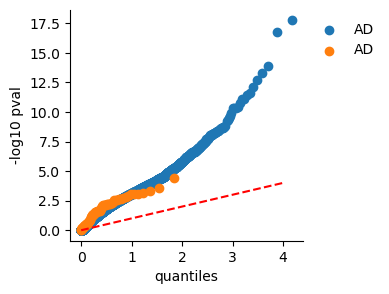

GOBP_AMYLOID_PRECURSOR_PROTEIN_BIOSYNTHETIC_PROCESS


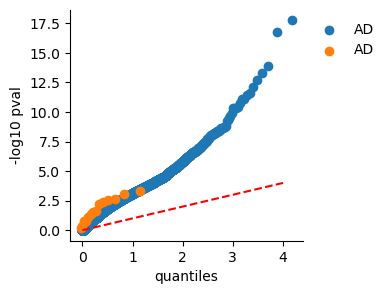

GOBP_NEGATIVE_REGULATION_OF_AMYLOID_PRECURSOR_PROTEIN_BIOSYNTHETIC_PROCESS


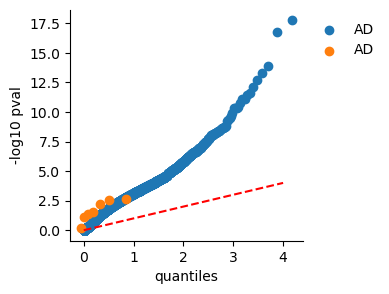

GOBP_AMYLOID_PRECURSOR_PROTEIN_CATABOLIC_PROCESS


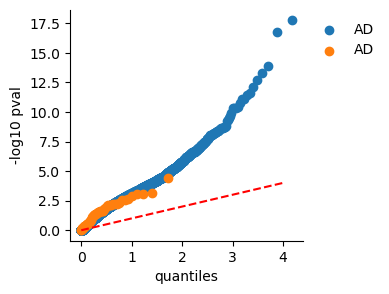

GOBP_AMYLOID_BETA_METABOLIC_PROCESS


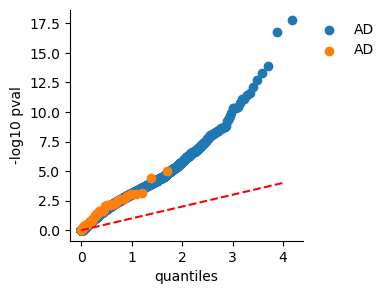

GOBP_AMYLOID_BETA_CLEARANCE


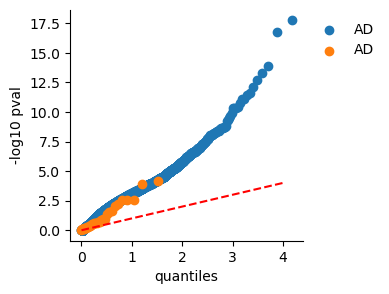

GOBP_AMYLOID_BETA_CLEARANCE_BY_TRANSCYTOSIS


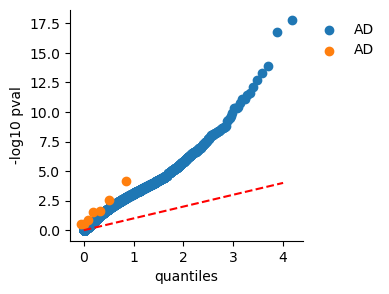

GOBP_AMYLOID_BETA_CLEARANCE_BY_CELLULAR_CATABOLIC_PROCESS


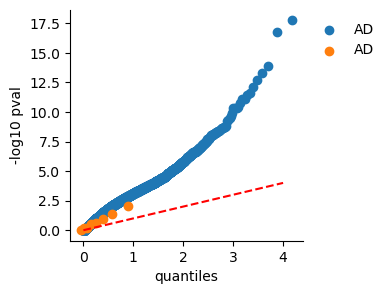

GOBP_REGULATION_OF_AMYLOID_BETA_CLEARANCE


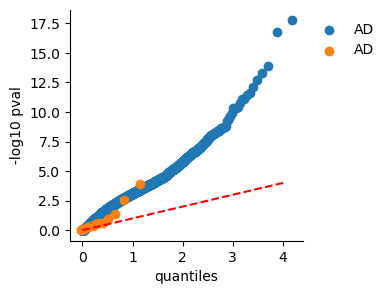

GOBP_NEGATIVE_REGULATION_OF_AMYLOID_BETA_CLEARANCE


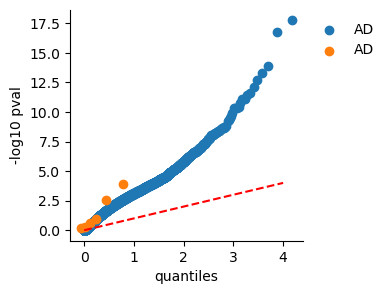

GOBP_POSITIVE_REGULATION_OF_AMYLOID_BETA_CLEARANCE


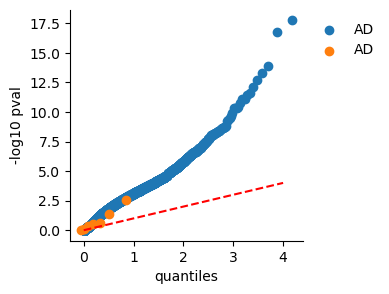

GOBP_POSITIVE_REGULATION_OF_AMYLOID_BETA_FORMATION


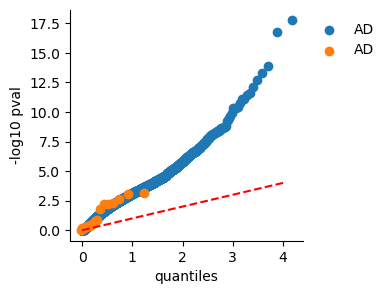

GOBP_REGULATION_OF_ASPARTIC_TYPE_ENDOPEPTIDASE_ACTIVITY_INVOLVED_IN_AMYLOID_PRECURSOR_PROTEIN_CATABOLIC_PROCESS


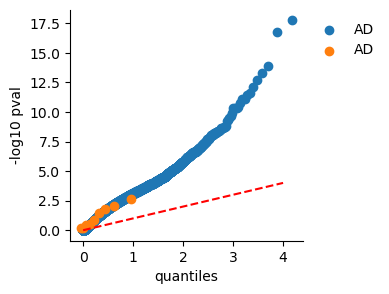

GOBP_REGULATION_OF_AMYLOID_PRECURSOR_PROTEIN_CATABOLIC_PROCESS


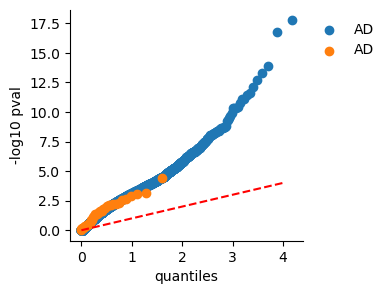

GOBP_NEGATIVE_REGULATION_OF_AMYLOID_PRECURSOR_PROTEIN_CATABOLIC_PROCESS


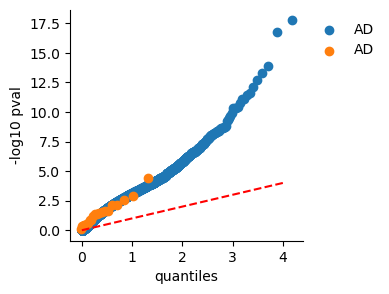

GOBP_POSITIVE_REGULATION_OF_AMYLOID_PRECURSOR_PROTEIN_CATABOLIC_PROCESS


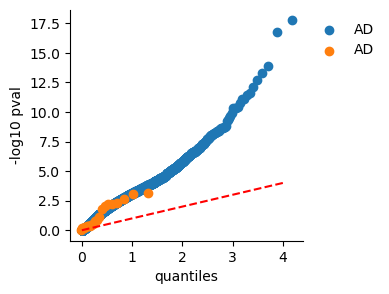

GOBP_RESPONSE_TO_AMYLOID_BETA


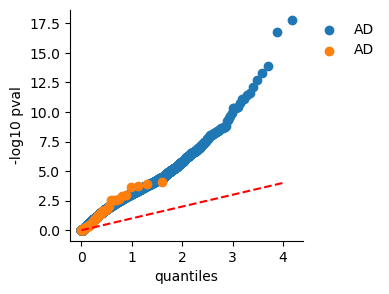

GOBP_CELLULAR_RESPONSE_TO_AMYLOID_BETA


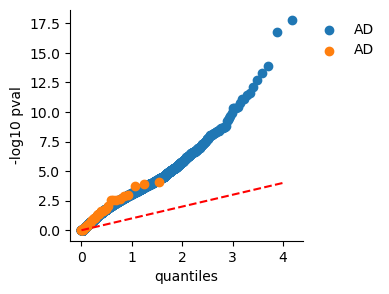

GOBP_REGULATION_OF_AMYLOID_FIBRIL_FORMATION


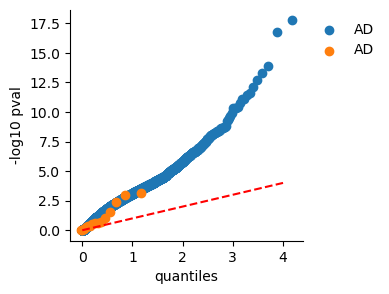

GOBP_NEGATIVE_REGULATION_OF_AMYLOID_FIBRIL_FORMATION


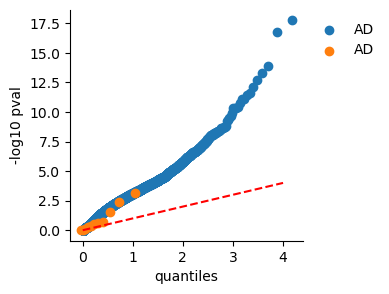

GOBP_POSITIVE_REGULATION_OF_AMYLOID_FIBRIL_FORMATION


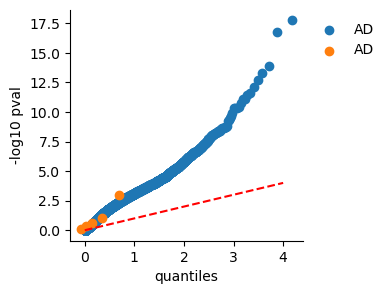

GOBP_AMYLOID_FIBRIL_FORMATION


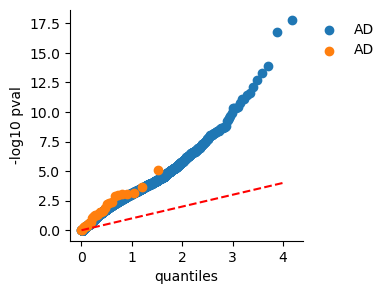

GOMF_AMYLOID_BETA_BINDING


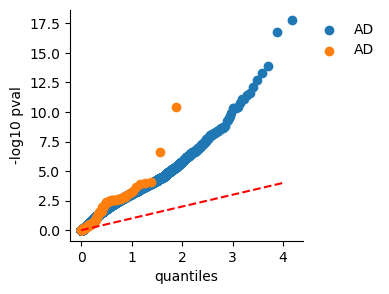

HP_RENAL_AMYLOIDOSIS


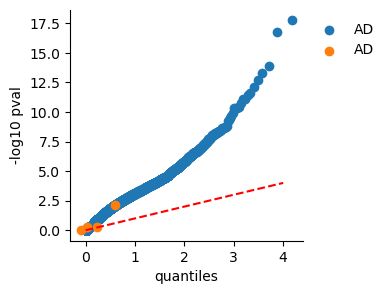

HP_GENERALIZED_AMYLOID_DEPOSITION


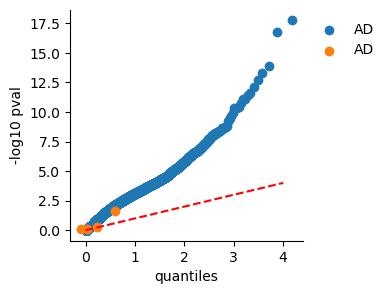

HP_DEPOSITS_IMMUNOREACTIVE_TO_BETA_AMYLOID_PROTEIN


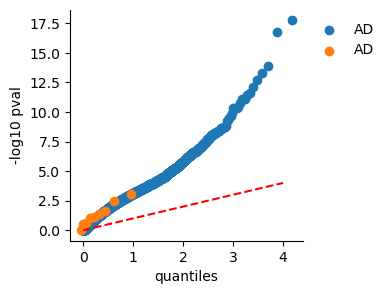

HP_AMYLOIDOSIS


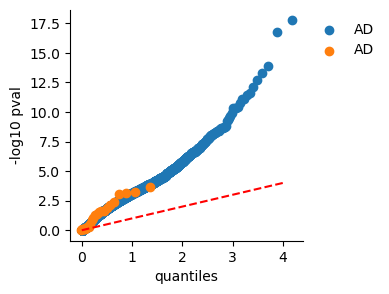

HP_CEREBRAL_AMYLOID_ANGIOPATHY


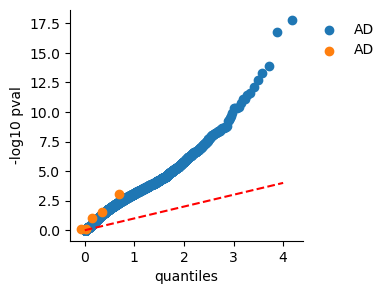

HP_CUTANEOUS_AMYLOIDOSIS


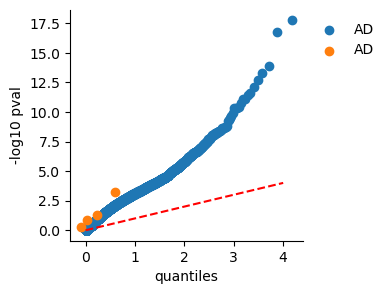

In [50]:
def get_qqplot(df, gene_list, genes_df, ensembl=False):
    if not ensembl:
        idx = pd.Index(genes_df.loc[genes_df.gene_name.isin(gene_list)].gene_id)
    else:
        idx = gene_list
        
    idx = df.index.intersection(idx)
    
    y = sorted(-np.log10(np.array(df.loc[idx].ACAT_pval)))
    x = -np.log10(np.linspace(1, len(y)+1, len(y))/len(y))[::-1]
    return x, y

for tag, genes in c2_dict.items():

    print(tag)

    x, y = get_qqplot(ad_pvals, ad_pvals.index, genes_df, ensembl=True)
    x2, y2 = get_qqplot(ad_pvals, genes, genes_df)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    plt.scatter(x, y, label='AD')
    plt.scatter(x2, y2, label='AD')
    plt.plot([0, 4], [0, 4], 'r--')
    ax.set_xlabel('quantiles')
    ax.set_ylabel('-log10 pval')
    ax.legend(frameon=False, bbox_to_anchor = (1, 1))
    ax.spines[['top', 'right']].set_visible(False)
    plt.show()

In [51]:
top_10_ensembl = ad_pvals.loc[ad_pvals.index.intersection(pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id))].sort_values('FDR').index[:10]
top_10 = [genes_df.loc[genes_df.gene_id == gene_id].gene_name.iloc[0] for gene_id in top_10_ensembl]

In [52]:
top_10_ensembl_ = ad_pvals.loc[ad_pvals.index.intersection(pd.Index(genes_df.loc[~genes_df.gene_name.isin(ad_dlpc_genes)].gene_id))].sort_values('FDR').index[:10]
top_10_ = [genes_df.loc[genes_df.gene_id == gene_id].gene_name.iloc[0] for gene_id in top_10_ensembl_]

In [53]:
gvc1 = pd.read_csv('../code/GVC_table1.tsv', sep='\t', skiprows=2, names = ['number', 'chrom', 'location', 'snv', 'gene'])
gvc2 = pd.read_csv('../code/GVC_table2.tsv', sep='\t', skiprows=2, names = ['number', 'gene', 'source', 'location'])
ru_extended = pd.read_csv('../code/overlap.min_corr_gwas95_qtl70.genelist.csv')

ad_genes_ru = pd.Index(gvc1.gene).union(pd.Index(gvc2.gene))
ad_gene_ru_id = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_genes_ru)].gene_id)

In [54]:
ad_pvals.loc[ad_pvals.FDR <= 0.05].index

Index(['ENSG00000148123', 'ENSG00000176155', 'ENSG00000135439',
       'ENSG00000164106', 'ENSG00000042286', 'ENSG00000205209',
       'ENSG00000101935', 'ENSG00000182054', 'ENSG00000260238',
       'ENSG00000102100',
       ...
       'ENSG00000259431', 'ENSG00000087206', 'ENSG00000064489',
       'ENSG00000117593', 'ENSG00000177374', 'ENSG00000239704',
       'ENSG00000068885', 'ENSG00000198133', 'ENSG00000159592',
       'ENSG00000090054'],
      dtype='object', name='gene_id', length=4943)

In [55]:
top_ad_ir_ensembl = ad_pvals.loc[ad_gene_ru_id.intersection(pd.Index(ad_boxplot.gene.unique()))].sort_values('ACAT_pval').index
top_ad_ir = [genes_df.loc[genes_df.gene_id == gene_id].gene_name.iloc[0] for gene_id in top_ad_ir_ensembl]

top_ad_ensembl = ad_pvals.loc[ad_gene_ru_id.intersection(ad_pvals.loc[ad_pvals.FDR <= 0.01].index)].sort_values('ACAT_pval').index
# top_ad_ensembl = top_ad_ensembl.difference(top_ad_ir_ensembl)
top_ad = [genes_df.loc[genes_df.gene_id == gene_id].gene_name.iloc[0] for gene_id in top_ad_ensembl]

In [56]:
y_idx = [list(ad_pvals.loc[ad_pvals.FDR <= 0.01].sort_values('ACAT_pval').index).index(gene) for gene in top_ad_ensembl]

In [57]:
# y_idx = [list(ad_pvals.loc[ad_pvals.FDR <= 0.05].sort_values('ACAT_pval').index).index(gene) for gene in top_ad_ir_ensembl]

In [58]:
ad_pvals.loc[ad_pvals.FDR <= 0.05].sort_values('ACAT_pval').index[y_idx]

Index(['ENSG00000186815', 'ENSG00000005379', 'ENSG00000120899',
       'ENSG00000091536', 'ENSG00000127415', 'ENSG00000143801',
       'ENSG00000138442'],
      dtype='object', name='gene_id')

In [59]:
top_ad_ir_ensembl

Index(['ENSG00000186815', 'ENSG00000120899', 'ENSG00000127415',
       'ENSG00000153814', 'ENSG00000103507', 'ENSG00000003147',
       'ENSG00000108379', 'ENSG00000154122'],
      dtype='object')

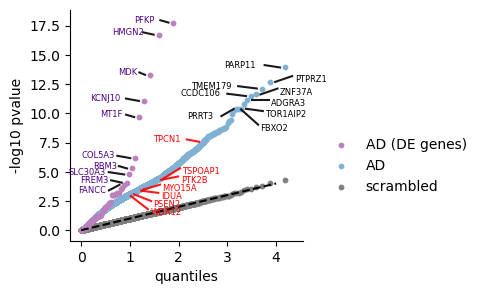

In [60]:
x3, y3 = get_qqplot(scrambled_ad_pvals, scrambled_ad_pvals.index, genes_df, ensembl=True)

x, y = get_qqplot(ad_pvals, ad_pvals.index.difference(pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id)), genes_df, ensembl=True)
x2, y2 = get_qqplot(ad_pvals, ad_dlpc_genes, genes_df)

a = sorted(y2)[-10:][::-1]
b = x2[:10:-1]

a_ = sorted(y)[-10:][::-1]
b_ = x[:10:-1]


fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(x2, y2, label='AD (DE genes)', c='#bc80bd', zorder=2, s=10)

plt.scatter(x, y, label='AD', c='#80b1d3', s=10)
plt.scatter(x3, y3, label='scrambled', c='tab:gray', s=10)
plt.plot([0, 4], [0, 4], linestyle='--', c='black')
ax.set_xlabel('quantiles')
ax.set_ylabel('-log10 pval')
ax.legend(frameon=False, bbox_to_anchor = (1.05, 0.5))
ax.spines[['top', 'right']].set_visible(False)
# plt.show()

for i in range(len(a)):
    gene = top_10[i]
    c = (len(gene)*0.15)+0.2

    gene_ = top_10_[i]
    c_ = (len(gene_)*0.15)+0.2
    if i >= 9:
        e = i*0.075
    # elif i >= 6:
    #     e = i*0.1
    else:
        e = 0


    ax.text(b[i]-c, a[i]-e, gene, size=6, c='indigo')
    ax.plot([b[i]-(c/3), b[i]-0.1], [a[i]+0.2-e, a[i]], c='black', alpha=0.9)



for i in range(len(a_)):
    gene = top_10_[i]
    if gene.startswith('ENSG'):
        continue
    c = (len(gene)*0.2)+0.05
    if i >= 9:
        e = i*0.2
    elif i >= 5:
        e = i*0.1
    else:
        e = 0

    if i >= 10:
        c = (len(gene)*0.25)+0.1
    if i%2 == 0:
        
        if i < 10:
            ax.text(b_[i]-c, a_[i]-e, gene, size=6)
            ax.plot([b_[i]-(c/3), b_[i]-0.1], [a_[i]+0.2-e, a_[i]], c='black', alpha=0.9)
        else:
            ax.text(b_[i]-c, a[i]-e+0.6, gene, size=6)
            ax.plot([b_[i]-(c/2), b_[i]-0.1], [a_[i]+0.8-e, a_[i]], c='black', alpha=0.9)
    else:
        ax.text(b_[i]+0.5, a_[i]-e, gene, size=6)
        ax.plot([b_[i]+0.1, b_[i]+0.45], [a_[i], a_[i]+0.5-e], c='black', alpha=0.9)

a_ = np.array(y[::-1])[y_idx]
b_ = np.array(x[::-1])[y_idx]



for i in range(len(a_)):
    gene = top_ad[i]
    if gene.startswith('ENSG'):
        continue
    c = (len(gene)*0.2)+0.05
    if i >= 1:
        e = i*0.7
    else:
        e = 0

    if i >= 10:
        c = (len(gene)*0.25)+0.1
    if i == 0:
        
        if i < 10:
            ax.text(b_[i]-c, a_[i]-e, gene, size=6, c='red')
            ax.plot([b_[i]-(c/3), b_[i]-0.1], [a_[i]+0.2-e, a_[i]], c='red', alpha=0.9)

    else:
        ax.text(b_[i]+0.5, a_[1]+1.1-e, gene, size=6, c='red')
        ax.plot([b_[i]+0.1, b_[i]+0.45], [a_[i], a_[1]+1.6-e], c='red', alpha=0.9)


ax.set_xlabel('quantiles')
ax.set_ylabel('-log10 pvalue')

plt.savefig('../code/scratch_figures/figure5/qqplot_ad_final.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/qqplot_ad_final.png', bbox_inches='tight', dpi=500)

In [145]:
top_10_ensembl.intersection(pd.Index(ad_boxplot.gene.unique()))

Index(['ENSG00000102317', 'ENSG00000115194', 'ENSG00000158169'], dtype='object')

In [143]:
pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id)#.intersection(ad_boxplot.index)

Index(['ENSG00000186891', 'ENSG00000198830', 'ENSG00000196517',
       'ENSG00000016602', 'ENSG00000099260', 'ENSG00000134253',
       'ENSG00000196154', 'ENSG00000183856', 'ENSG00000177807',
       'ENSG00000188783', 'ENSG00000133069', 'ENSG00000203668',
       'ENSG00000067057', 'ENSG00000170324', 'ENSG00000138336',
       'ENSG00000130592', 'ENSG00000176697', 'ENSG00000110492',
       'ENSG00000053702', 'ENSG00000166535', 'ENSG00000086159',
       'ENSG00000139410', 'ENSG00000126803', 'ENSG00000166831',
       'ENSG00000158865', 'ENSG00000197471', 'ENSG00000198417',
       'ENSG00000135736', 'ENSG00000166592', 'ENSG00000176387',
       'ENSG00000177374', 'ENSG00000179477', 'ENSG00000005381',
       'ENSG00000108932', 'ENSG00000153822', 'ENSG00000070731',
       'ENSG00000141433', 'ENSG00000180777', 'ENSG00000196415',
       'ENSG00000080573', 'ENSG00000188039', 'ENSG00000105655',
       'ENSG00000010310', 'ENSG00000105419', 'ENSG00000142227',
       'ENSG00000132031', 'ENSG000001151

In [51]:
ad_genes = ad_pvals.loc[ad_pvals.FDR <= 0.05].index
ad_gene_names = list(genes_df.loc[genes_df.gene_id.isin(ad_genes)].gene_name)

2024-10-06 23:26:44,094 [INFO] User defined gene sets is given: ../code/c5.all.v2023.1.Hs.symbols.gmt
2024-10-06 23:26:44,484 [INFO] Run: c5.all.v2023.1.Hs.symbols.gmt 
2024-10-06 23:26:52,320 [INFO] Background is not set! Use all 19384 genes in c5.all.v2023.1.Hs.symbols.gmt.
2024-10-06 23:26:57,029 [INFO] Done.


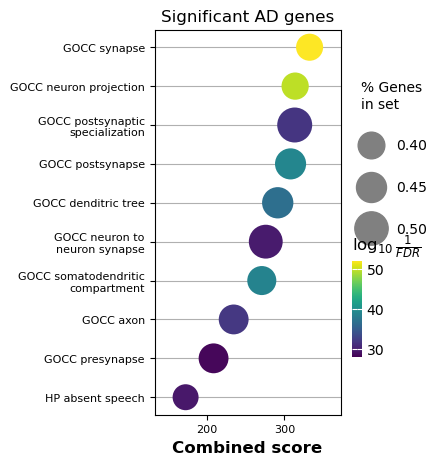

In [52]:
# GSEApy gives some annoying info messages that we don't need...
import warnings
warnings.filterwarnings("ignore")


# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=ad_gene_names, # or gene_list=glist
                 gene_sets=['../code/c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dp = dotplot(enr2.res2d, title='Top AD affected genes',cmap='viridis', size=8, figsize=(3,5))
y = ['HP absent speech', 'GOCC presynapse', 'GOCC axon', 'GOCC somatodendritic\ncompartment', 'GOCC neuron to\nneuron synapse',
     'GOCC denditric tree', 'GOCC postsynapse', 'GOCC postsynaptic\nspecialization', 'GOCC neuron projection', 'GOCC synapse']
# y = ['GOCC synapse', 'GOCC mitochondrion', 'HP language impairment', 'GOCC denditric tree', 'GOCC neuron projection', 'GOCC axon',
#      'GOCC somatodendritic\ncompartment', 'HP absent speech', 'GOBP cell-cell adhesion via\nplasma membrane\nadhesion molecules',
#      'GOBP homophilic cell-cell\nadhesion via plasma membrane\nadhesion molecules']
dp.set_yticklabels(y, size=8)
dp.set_title('Significant AD genes', size=12)
dp.set_xlabel('Combined score', size=12)
dp.set_xticks([200, 300])
dp.set_xticklabels(['200', '300'], size=8)

plt.savefig('../code/scratch_figures/figure5/GSEA_AD.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/GSEA_AD.png', bbox_inches='tight', dpi=500)

In [281]:
ad_genes = pd.Index(ad_boxplot_all.gene.unique())
ad_gene_names = list(genes_df.loc[genes_df.gene_id.isin(ad_genes)].gene_name)

2024-10-08 00:58:02,351 [INFO] User defined gene sets is given: ../code/c5.all.v2023.1.Hs.symbols.gmt
2024-10-08 00:58:02,627 [INFO] Run: c5.all.v2023.1.Hs.symbols.gmt 
2024-10-08 00:58:10,134 [INFO] Background is not set! Use all 19384 genes in c5.all.v2023.1.Hs.symbols.gmt.
2024-10-08 00:58:14,101 [INFO] Done.


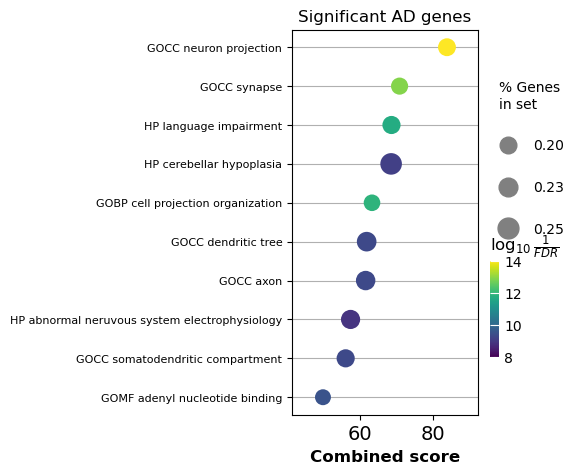

In [285]:
# GSEApy gives some annoying info messages that we don't need...
import warnings
warnings.filterwarnings("ignore")


# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=ad_gene_names, # or gene_list=glist
                 gene_sets=['../code/c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dp = dotplot(enr2.res2d, title='Top AD affected genes',cmap='viridis', size=10, figsize=(3,5))
y = ['GOMF adenyl nucleotide binding', 'GOCC somatodendritic compartment', 'HP abnormal neruvous system electrophysiology', 'GOCC axon',
    'GOCC dendritic tree', 'GOBP cell projection organization', 'HP cerebellar hypoplasia', 'HP language impairment', 'GOCC synapse', 'GOCC neuron projection']
# y = ['GOCC synapse', 'GOCC mitochondrion', 'HP language impairment', 'GOCC denditric tree', 'GOCC neuron projection', 'GOCC axon',
#      'GOCC somatodendritic\ncompartment', 'HP absent speech', 'GOBP cell-cell adhesion via\nplasma membrane\nadhesion molecules',
#      'GOBP homophilic cell-cell\nadhesion via plasma membrane\nadhesion molecules']
dp.set_yticklabels(y, size=8)
dp.set_title('Significant AD genes', size=12)
dp.set_xlabel('Combined score', size=12)
# dp.set_xticks([200, 300])
# dp.set_xticklabels(['200', '300'], size=8)

plt.savefig('../code/scratch_figures/figure5/GSEA_AD_IR.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/GSEA_AD_IR.png', bbox_inches='tight', dpi=500)

In [41]:
introns_bed = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_1e3.bed.gz', sep='\t')
introns_bed2 = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_1e2.bed.gz', sep='\t')
introns_bed3 = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_5e2.bed.gz', sep='\t')

introns_bed4 = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_AD_IR_plots_1e3.bed.gz', sep='\t')
introns_bed5 = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_AD_IR_plots_1e2.bed.gz', sep='\t')
introns_bed6 = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_AD_IR_plots_5e2.bed.gz', sep='\t')


introns_bed = pd.concat([introns_bed, introns_bed2, introns_bed3, introns_bed4, introns_bed5, introns_bed6], axis=0)
introns_bed.index = range(introns_bed.shape[0])

coverage_zmean = introns_bed.groupby(['gene'])[[f'braaks_{str(i)}_zloadings.PCC' for i in range(7)]].mean()

In [42]:
import random
from sklearn.cluster import KMeans

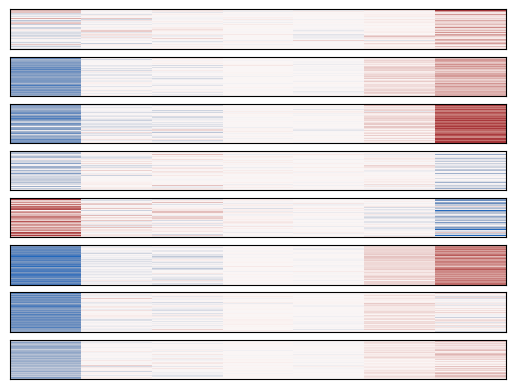

In [44]:
KM = KMeans(random_state=0).fit(coverage_zmean)
km_labels = KM.labels_
fig, axes = plt.subplots(nrows=8)#, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    slice_zmean = coverage_zmean.loc[KM.labels_ == i]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

In [45]:
i_order = [2, 5, 1, 7, 6, 0, 3, 4]
# i_order = [4, 1, 6, 3, 5, 2, 0, 7]
height_ratios = [(km_labels == i).mean() for i in i_order]

In [61]:
top_10_ensembl

Index(['ENSG00000067057', 'ENSG00000198830', 'ENSG00000110492',
       'ENSG00000177807', 'ENSG00000198417', 'ENSG00000080573',
       'ENSG00000102317', 'ENSG00000115194', 'ENSG00000183090',
       'ENSG00000158169'],
      dtype='object', name='gene_id')

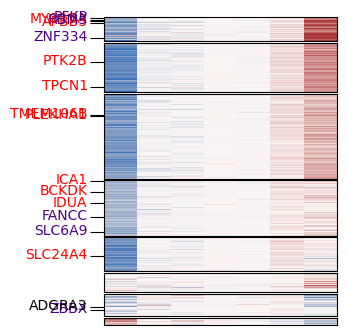

In [62]:
fig, axes = plt.subplots(figsize = (3, 4), nrows=8, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    slice_zmean = coverage_zmean.loc[KM.labels_ == i_order[i]]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    
    heatmap_idx = coverage_zmean.loc[km_labels == i_order[i]].index
    
    ru_in_heatmap = ad_gene_ru_id.intersection(heatmap_idx)

    ax_idx = []
    
    if len(ru_in_heatmap) > 0:
        # print(len(ru_in_heatmap))
        idx = np.arange(len(heatmap_idx))
        for ru_gene in ru_in_heatmap:
            ru_idx = idx[pd.Series(heatmap_idx) == ru_gene]
            axes[i].set_yticks(ru_idx)

            gene_name = genes_df.loc[genes_df.gene_id == ru_gene].gene_name.iloc[0]
            
            axes[i].text(-0.5, ru_idx+15, gene_name, c='red', horizontalalignment='right')
        ru_idx = list(idx[pd.Series(heatmap_idx).isin(ad_gene_ru_id)])
        ax_idx.extend(ru_idx)

    DEGenes = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id)
    DEG_in_heatmap = heatmap_idx.intersection(DEGenes)
    
    if len(DEG_in_heatmap) > 0:
        # print(len(ru_in_heatmap))
        idx = np.arange(len(heatmap_idx))
        for de_gene in DEG_in_heatmap:
            deg_idx = idx[pd.Series(heatmap_idx) == de_gene]
            axes[i].set_yticks(deg_idx)

            gene_name = genes_df.loc[genes_df.gene_id == de_gene].gene_name.iloc[0]
            
            axes[i].text(-0.5, deg_idx+15, gene_name, c='indigo', horizontalalignment='right')
        deg_idx = list(idx[pd.Series(heatmap_idx).isin(pd.Index(DEGenes))])
        ax_idx.extend(deg_idx)


    DEGenes = top_10_ensembl_
    DEG_in_heatmap = heatmap_idx.intersection(DEGenes)
    
    if len(DEG_in_heatmap) > 0:
        # print(len(ru_in_heatmap))
        idx = np.arange(len(heatmap_idx))
        for de_gene in DEG_in_heatmap:
            deg_idx = idx[pd.Series(heatmap_idx) == de_gene]
            axes[i].set_yticks(deg_idx)

            gene_name = genes_df.loc[genes_df.gene_id == de_gene].gene_name.iloc[0]
            
            axes[i].text(-0.5, deg_idx+15, gene_name, c='black', horizontalalignment='right')
        deg_idx = list(idx[pd.Series(heatmap_idx).isin(pd.Index(DEGenes))])
        ax_idx.extend(deg_idx)

    if len(ax_idx) > 0:
        axes[i].set_yticks(ax_idx)
    else:
        axes[i].set_yticks([])
    axes[i].set_xticks([])

    axes[i].tick_params(axis='both', which='major', length=10)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

# axes[1].text(-4, -5, 'prueba')

plt.savefig('../code/scratch_figures/figure5/IR_heatmap.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_heatmap.png', bbox_inches='tight', dpi=500)

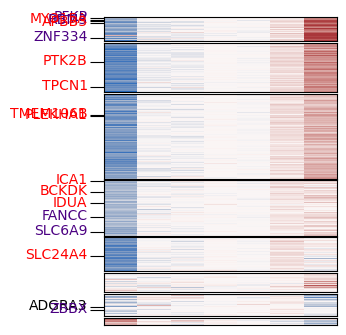

In [64]:
DEGenes = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id)
genes_to_highlight = ad_gene_ru_id.union(DEGenes).union(top_10_ensembl_)

gene_list_order = []

stacked = 0

fig, axes = plt.subplots(figsize = (3, 4), nrows=8, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    slice_zmean = coverage_zmean.loc[KM.labels_ == i_order[i]]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    
    heatmap_idx = coverage_zmean.loc[km_labels == i_order[i]].index

    highlight_in_heatmap = genes_to_highlight.intersection(heatmap_idx)
    #ru_in_heatmap = ad_gene_ru_id.intersection(heatmap_idx)

    ax_idx = []
    
    if len(highlight_in_heatmap) > 0:
        # print(len(ru_in_heatmap))
        idx = np.arange(len(heatmap_idx))
        for highlight_gene in highlight_in_heatmap:
            ru_idx = idx[pd.Series(heatmap_idx) == highlight_gene]
            axes[i].set_yticks(ru_idx)

            gene_name = genes_df.loc[genes_df.gene_id == highlight_gene].gene_name.iloc[0]
            if highlight_gene in ad_gene_ru_id:
                tag_color = 'red'
            elif highlight_gene in DEGenes:
                tag_color = 'indigo'
            else:
                tag_color = 'black'
            gene_list_order.append(gene_name)
            axes[i].text(-0.5, ru_idx+15, gene_name, c=tag_color, horizontalalignment='right')
        ru_idx = list(idx[pd.Series(heatmap_idx).isin(genes_to_highlight)])
        ax_idx.extend(ru_idx)

    
    # DEG_in_heatmap = heatmap_idx.intersection(DEGenes)
    
    # if len(DEG_in_heatmap) > 0:
    #     # print(len(ru_in_heatmap))
    #     idx = np.arange(len(heatmap_idx))
    #     for de_gene in DEG_in_heatmap:
    #         deg_idx = idx[pd.Series(heatmap_idx) == de_gene]
    #         axes[i].set_yticks(deg_idx)

    #         gene_name = genes_df.loc[genes_df.gene_id == de_gene].gene_name.iloc[0]
            
    #         axes[i].text(-0.5, deg_idx+15, gene_name, c='indigo', horizontalalignment='right')
    #     deg_idx = list(idx[pd.Series(heatmap_idx).isin(pd.Index(DEGenes))])
    #     ax_idx.extend(deg_idx)


    # DEGenes = top_10_ensembl_
    # DEG_in_heatmap = heatmap_idx.intersection(DEGenes)
    
    # if len(DEG_in_heatmap) > 0:
    #     # print(len(ru_in_heatmap))
    #     idx = np.arange(len(heatmap_idx))
    #     for de_gene in DEG_in_heatmap:
    #         deg_idx = idx[pd.Series(heatmap_idx) == de_gene]
    #         axes[i].set_yticks(deg_idx)

    #         gene_name = genes_df.loc[genes_df.gene_id == de_gene].gene_name.iloc[0]
            
    #         axes[i].text(-0.5, deg_idx+15, gene_name, c='black', horizontalalignment='right')
    #     deg_idx = list(idx[pd.Series(heatmap_idx).isin(pd.Index(DEGenes))])
    #     ax_idx.extend(deg_idx)

    if len(ax_idx) > 0:
        axes[i].set_yticks(ax_idx)
    else:
        axes[i].set_yticks([])
    axes[i].set_xticks([])

    axes[i].tick_params(axis='both', which='major', length=10)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

# axes[1].text(-4, -5, 'prueba')

# plt.savefig('../code/scratch_figures/figure5/IR_heatmap.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure5/IR_heatmap.png', bbox_inches='tight', dpi=500)

In [105]:
gene_list_order
position_add = [0, 80, 160, 240, 240, 200, 140, 65, 150, 0, 0, 0, 0, 0, 0, -40, 20]

In [106]:
len(gene_list_order)

17

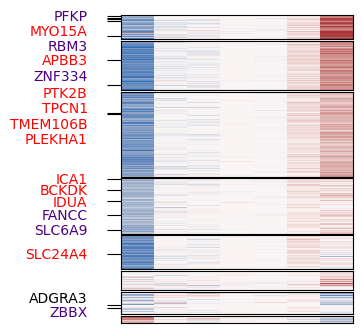

In [161]:
DEGenes = pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id)
genes_to_highlight = ad_gene_ru_id.union(DEGenes).union(top_10_ensembl_)

gene_list_order = []

j = 0

fig, axes = plt.subplots(figsize = (3, 4), nrows=8, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    slice_zmean = coverage_zmean.loc[KM.labels_ == i_order[i]]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    
    heatmap_idx = coverage_zmean.loc[km_labels == i_order[i]].index

    highlight_in_heatmap = genes_to_highlight.intersection(heatmap_idx)
    #ru_in_heatmap = ad_gene_ru_id.intersection(heatmap_idx)

    ax_idx = []
    
    if len(highlight_in_heatmap) > 0:
        # print(len(ru_in_heatmap))
        idx = np.arange(len(heatmap_idx))
        for highlight_gene in highlight_in_heatmap:
            ru_idx = idx[pd.Series(heatmap_idx) == highlight_gene]
            axes[i].set_yticks(ru_idx)

            gene_name = genes_df.loc[genes_df.gene_id == highlight_gene].gene_name.iloc[0]
            if highlight_gene in ad_gene_ru_id:
                tag_color = 'red'
            elif highlight_gene in DEGenes:
                tag_color = 'indigo'
            else:
                tag_color = 'black'
            gene_list_order.append(gene_name)
            axes[i].text(-1, ru_idx+30 + position_add[j], gene_name, c=tag_color, horizontalalignment='right')
            j += 1
        ru_idx = list(idx[pd.Series(heatmap_idx).isin(genes_to_highlight)])
        ax_idx.extend(ru_idx)

    
    if len(ax_idx) > 0:
        axes[i].set_yticks(ax_idx)
    else:
        axes[i].set_yticks([])
    axes[i].set_xticks([])

    axes[i].tick_params(axis='both', which='major', length=10)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

# axes[1].text(-4, -5, 'prueba')

plt.savefig('../code/scratch_figures/figure5/IR_heatmap.PCC.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_heatmap.PCC.png', bbox_inches='tight', dpi=500)

In [109]:
pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id).intersection(coverage_zmean.index)

Index(['ENSG00000196517', 'ENSG00000067057', 'ENSG00000198185',
       'ENSG00000169064', 'ENSG00000158169', 'ENSG00000102317'],
      dtype='object')

In [110]:
genes_df.loc[genes_df.gene_id == ru_gene].gene_name.iloc[0]

'SLC24A4'

In [111]:
def get_gencode_bed(gencode, gene):
    gencode_sub = gencode.loc[(gencode.gene == gene)].dropna()
    if gencode_sub.appris.apply(lambda x: 'appris_principal_' in x).any():
        gencode_transcript = gencode_sub.loc[gencode_sub.appris.apply(lambda x: 'appris_principal_' in x)]
    else:
        gencode_transcript = gencode_sub.loc[gencode_sub.mane == 'MANE_Select']

    gencode_bed = BedTool.from_dataframe(gencode_transcript).merge()

    gencode_full_gene = pd.DataFrame()
    gencode_full_gene['chrom'] = [gencode_transcript.iloc[0, 0]]
    gencode_full_gene['start'] = [gencode_transcript.start.min()]
    gencode_full_gene['end'] = [gencode_transcript.end.max()]

    gencode_full_gene = BedTool.from_dataframe(gencode_full_gene)
    
    return gencode_bed, gencode_full_gene

def get_intron_mean_position(bed, start, end):

    start_i = (bed.start - start)/(end-start)
    end_i = (bed.end - start)/(end-start)

    intervals = list(zip(start_i, end_i))


    # Calculate the lengths of the intervals
    lengths = [(end - start) for start, end in intervals]
    
    # Calculate the total length
    total_length = sum(lengths)
    
    # Find the point where half of the total length is reached
    half_length = total_length / 2.0
    
    # Find the cumulative lengths
    cumulative_length = 0.0
    for (start, end), length in zip(intervals, lengths):
        cumulative_length += length
        if cumulative_length >= half_length:
            # We need to move half_length - (cumulative_length - length) into the current interval
            return start + (half_length - (cumulative_length - length))
    
    # If we reach here, something went wrong (e.g., empty intervals list)
    return None

In [114]:
order_df = pd.DataFrame()
gene_list = []
position = []
strand_list = []
# pos = 0
colores = sns.color_palette("vlag", 10)
for gene in tqdm(introns_bed.gene.unique(), position=0, leave=True):
    strand = gencode.loc[gencode.gene == gene].strand.iloc[0]
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]
    pos = get_intron_mean_position(introns_bed.loc[introns_bed.gene == gene], start_, end_)
    if strand == '-':
        pos = 1-pos
    position.append(pos)
    gene_list.append(gene)
    strand_list.append(strand)
    
    # for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
    #     int_start = (row.start - start_)/(end_ - start_)
    #     int_end = (row.end - start_)/(end_ - start_)
    #     low_score = row['braaks_0_zloadings.PCC']
    #     high_score = row['braaks_6_zloadings.PCC']
    #     plt.plot([int_start, int_end], [pos, pos], c=select_color(low_score, colores))
    #     plt.plot([2+int_start, 2+int_end], [pos, pos], c=select_color(high_score, colores))
    # pos -= 1

order_df['gene'] = gene_list
order_df['position'] = position
order_df['strand'] = strand_list

100%|███████████████████████████████████████| 1802/1802 [05:48<00:00,  5.18it/s]


In [115]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the color palette
colores = sns.color_palette("vlag", 10)

# Function to select the color based on z value
def select_color(z, colores):
    if z <= -1:
        out_color = colores[0]
    elif z <= -0.5:
        out_color = colores[1]
    elif z <= -0.2:
        out_color = colores[2]
    elif z <= -0.1:
        out_color = colores[3]
    elif z <= 0:
        out_color = colores[4]
    elif z >= 1:
        out_color = colores[9]
    elif z >= 0.5:
        out_color = colores[8]
    elif z >= 0.2:
        out_color = colores[7]
    elif z >= 0.1:
        out_color = colores[6]
    elif z > 0.0:
        out_color = colores[5]
    else:
        out_color = 'gray'
    return out_color

def add_vertical_colorbar_to_ax(ax, colores):
    # Create a custom colormap and norm for the colorbar
    cmap = ListedColormap(colores)
    bounds = [-1.5, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 1.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # Add the colorbar to the right of the ax, vertically
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax, orientation='vertical', boundaries=bounds, pad=0.1
    )
    cbar.set_label('Z score')


import matplotlib.colors as mcolors

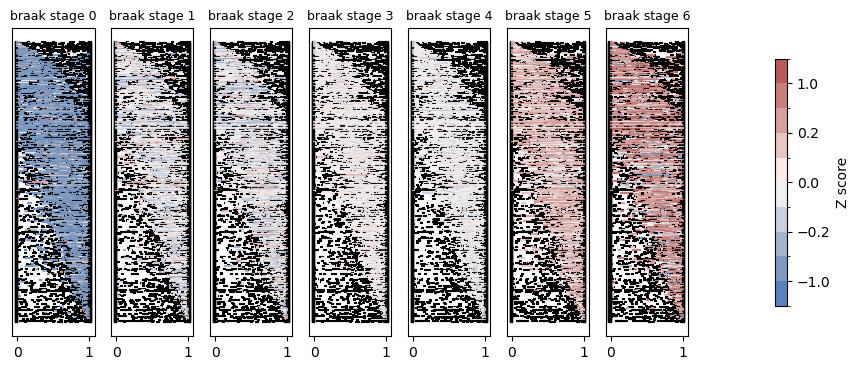

In [98]:
pos = 0

fig, axes = plt.subplots(ncols = 8, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1], wspace = 0.05})

colores = sns.color_palette("vlag", 10)
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(7):
        axes[i].plot([-0.02, 0], [pos, pos], c='black')
        axes[i].plot([1, 1.02], [pos, pos], c='black')
        axes[i].spines[['top', 'left', 'right']].set_visible(False)

        if i == 0:
            
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(7):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black')


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i].plot([int_start, int_end], [pos, pos], c=select_color(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i].set_yticks([])
    axes[i].set_title(f'braak stage {str(i)}', size=9)

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[7].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[7].set_xticks([])
axes[7].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[7], colores)
plt.show()

In [116]:
fdr_01 = pd.Index(ad_boxplot.loc[ad_boxplot.FDR <= 0.01].gene.unique())

In [117]:
order_df

,gene,position,strand
0,ENSG00000000460,0.387681,+
1,ENSG00000001497,0.071783,-
2,ENSG00000036448,0.849024,+
3,ENSG00000044446,0.688531,-
4,ENSG00000049246,0.498070,+
...,...,...,...
1797,ENSG00000269699,0.143598,-
1798,ENSG00000274349,0.079026,+
1799,ENSG00000278535,0.175806,+
1800,ENSG00000286219,0.998284,+


In [118]:
# heatmap_idx = coverage_zmean.loc[km_labels == i_order[i]].index
    
#     ru_in_heatmap = ad_gene_ru_id.intersection(heatmap_idx)

#     ax_idx = []
    
#     if len(ru_in_heatmap) > 0:
#         # print(len(ru_in_heatmap))
#         idx = np.arange(len(heatmap_idx))
#         for ru_gene in ru_in_heatmap:
#             ru_idx = idx[pd.Series(heatmap_idx) == ru_gene]
#             axes[i].set_yticks(ru_idx)

#             gene_name = genes_df.loc[genes_df.gene_id == ru_gene].gene_name.iloc[0]
            
#             axes[i].text(-0.5, ru_idx+15, gene_name, c='red', horizontalalignment='right')

In [133]:
stackings = [0, 0, 35, 70, 70, 0, 0, 0, 0, 80, 80, 130, 60, 0, 45, 120, 110]

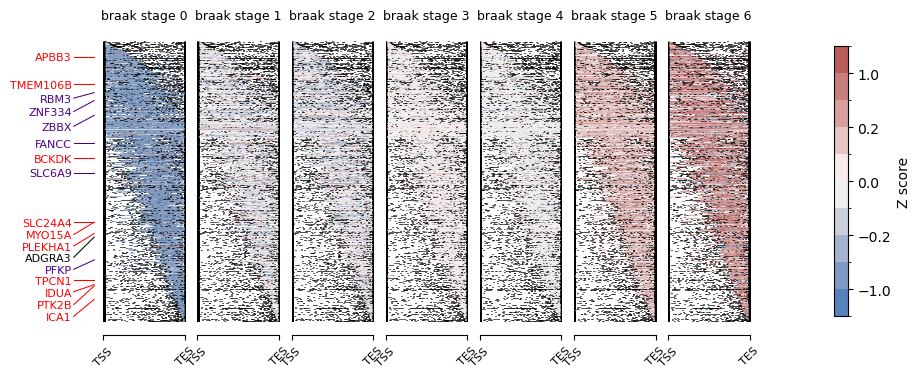

In [165]:
pos = 0

fig, axes = plt.subplots(ncols = 9, figsize=(10, 4), gridspec_kw={'width_ratios': [0.25, 1, 1, 1, 1, 1, 1, 1, 1], 'wspace':0.05})

colores = sns.color_palette("vlag", 10)
counts_tag = 0
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(1, 8):
        axes[i].plot([-0.02, 0], [pos, pos], c='black', linewidth=0.5)
        axes[i].plot([1, 1.02], [pos, pos], c='black', linewidth=0.5)
        



    axes[0].spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    if gene in genes_to_highlight:
        gene_name = genes_df.loc[genes_df.gene_id == gene].gene_name.iloc[0]

        if gene in ad_gene_ru_id:
            tag_color = 'red'
        elif gene in DEGenes:
            tag_color = 'indigo'
        else:
            tag_color = 'black'

        stack = stackings[counts_tag]
        
        # if stack > 0:
        #     axes[0].plot([-0.2, -0.05], [pos, pos], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.4, -0.3], [pos-stack, pos-stack], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.3, -0.2], [pos-stack, pos], c=tag_color, linewidth=0.75)
        #     axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        # else:
        axes[0].plot([-0.4, -0.05], [pos-stack, pos], c=tag_color, linewidth=0.75)
        axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        counts_tag += 1
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(1, 8):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black', linewidth=0.5)


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.PCC']
            axes[i+1].plot([int_start, int_end], [pos, pos], linewidth=0.5, c=select_color(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i+1].set_yticks([])
    axes[i+1].set_title(f'braak stage {str(i)}', size=9)

for i in range(1, 8):
    axes[i].spines[['top', 'left', 'right']].set_visible(False)

    # axes[i].set_xlim((-0.075, 1.075))
    axes[i].set_xticks((-0.02, 1.02))
    axes[i].set_xticklabels(['TSS', 'TES'], size=8, rotation=45)
    axes[i].spines['bottom'].set_bounds(-0.02, 1.02)
    
# axes[0].set_ylim((-1891.05, 90.05000000000001))
axes[0].set_ylim(axes[5].get_ylim())

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[8].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[8].set_xticks([])
axes[8].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[8], colores)

plt.savefig('../code/scratch_figures/figure5/IR_progression.PCC.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_progression.PCC.png', bbox_inches='tight', dpi=500)

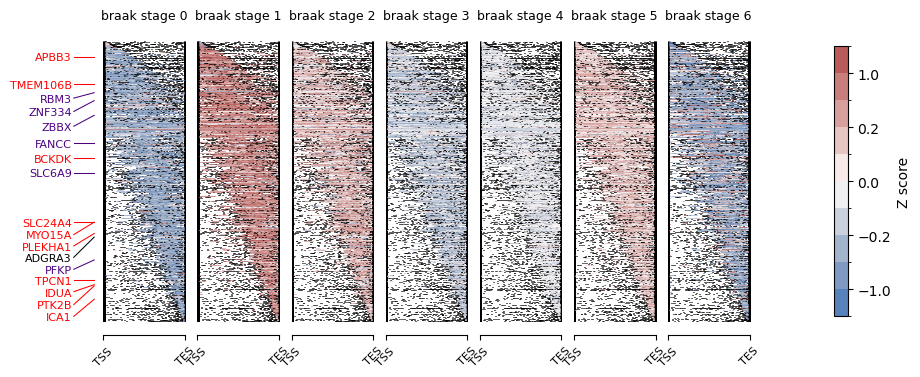

In [166]:
pos = 0

fig, axes = plt.subplots(ncols = 9, figsize=(10, 4), gridspec_kw={'width_ratios': [0.25, 1, 1, 1, 1, 1, 1, 1, 1], 'wspace':0.05})

colores = sns.color_palette("vlag", 10)
counts_tag = 0
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(1, 8):
        axes[i].plot([-0.02, 0], [pos, pos], c='black', linewidth=0.5)
        axes[i].plot([1, 1.02], [pos, pos], c='black', linewidth=0.5)
        



    axes[0].spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    if gene in genes_to_highlight:
        gene_name = genes_df.loc[genes_df.gene_id == gene].gene_name.iloc[0]

        if gene in ad_gene_ru_id:
            tag_color = 'red'
        elif gene in DEGenes:
            tag_color = 'indigo'
        else:
            tag_color = 'black'

        stack = stackings[counts_tag]
        
        # if stack > 0:
        #     axes[0].plot([-0.2, -0.05], [pos, pos], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.4, -0.3], [pos-stack, pos-stack], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.3, -0.2], [pos-stack, pos], c=tag_color, linewidth=0.75)
        #     axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        # else:
        axes[0].plot([-0.4, -0.05], [pos-stack, pos], c=tag_color, linewidth=0.75)
        axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        counts_tag += 1
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(1, 8):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black', linewidth=0.5)


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings.DLPC']
            axes[i+1].plot([int_start, int_end], [pos, pos], linewidth=0.5, c=select_color(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i+1].set_yticks([])
    axes[i+1].set_title(f'braak stage {str(i)}', size=9)

for i in range(1, 8):
    axes[i].spines[['top', 'left', 'right']].set_visible(False)

    # axes[i].set_xlim((-0.075, 1.075))
    axes[i].set_xticks((-0.02, 1.02))
    axes[i].set_xticklabels(['TSS', 'TES'], size=8, rotation=45)
    axes[i].spines['bottom'].set_bounds(-0.02, 1.02)
    
# axes[0].set_ylim((-1891.05, 90.05000000000001))
axes[0].set_ylim(axes[5].get_ylim())

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[8].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[8].set_xticks([])
axes[8].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[8], colores)

plt.savefig('../code/scratch_figures/figure5/IR_progression.DLPC.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_progression.DLPC.png', bbox_inches='tight', dpi=500)

In [177]:
introns_bed['braaks_1_zloadings.DLPC'].mean()

0.4786298354036124

In [181]:
fdr_ = ad_boxplot.groupby('gene').FDR.mean()
fdr_.loc[fdr_ <= 1e-3]

gene
ENSG00000000460    0.000557
ENSG00000001497    0.000109
ENSG00000036448    0.000247
ENSG00000040487    0.000413
ENSG00000044446    0.000318
                     ...   
ENSG00000283930    0.000010
ENSG00000284989    0.000061
ENSG00000285000    0.000134
ENSG00000285382    0.000142
ENSG00000285942    0.000574
Name: FDR, Length: 111, dtype: float64

In [221]:
introns_bed.loc[:, 'braaks_6_zloadings.PCC'].mean()

0.24715553771454027

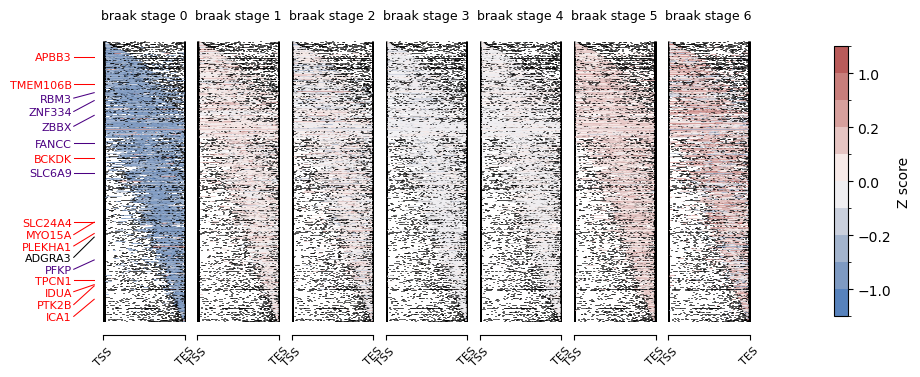

In [167]:
pos = 0

fig, axes = plt.subplots(ncols = 9, figsize=(10, 4), gridspec_kw={'width_ratios': [0.25, 1, 1, 1, 1, 1, 1, 1, 1], 'wspace':0.05})

colores = sns.color_palette("vlag", 10)
counts_tag = 0
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(1, 8):
        axes[i].plot([-0.02, 0], [pos, pos], c='black', linewidth=0.5)
        axes[i].plot([1, 1.02], [pos, pos], c='black', linewidth=0.5)
        



    axes[0].spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    if gene in genes_to_highlight:
        gene_name = genes_df.loc[genes_df.gene_id == gene].gene_name.iloc[0]

        if gene in ad_gene_ru_id:
            tag_color = 'red'
        elif gene in DEGenes:
            tag_color = 'indigo'
        else:
            tag_color = 'black'

        stack = stackings[counts_tag]
        
        # if stack > 0:
        #     axes[0].plot([-0.2, -0.05], [pos, pos], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.4, -0.3], [pos-stack, pos-stack], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.3, -0.2], [pos-stack, pos], c=tag_color, linewidth=0.75)
        #     axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        # else:
        axes[0].plot([-0.4, -0.05], [pos-stack, pos], c=tag_color, linewidth=0.75)
        axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        counts_tag += 1
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(1, 8):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black', linewidth=0.5)


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i in range(7):
            col_score = row[f'braaks_{str(i)}_zloadings']
            axes[i+1].plot([int_start, int_end], [pos, pos], linewidth=0.5, c=select_color(col_score, colores))
    pos -= 1

for i in range(7):
    axes[i+1].set_yticks([])
    axes[i+1].set_title(f'braak stage {str(i)}', size=9)

for i in range(1, 8):
    axes[i].spines[['top', 'left', 'right']].set_visible(False)

    # axes[i].set_xlim((-0.075, 1.075))
    axes[i].set_xticks((-0.02, 1.02))
    axes[i].set_xticklabels(['TSS', 'TES'], size=8, rotation=45)
    axes[i].spines['bottom'].set_bounds(-0.02, 1.02)
    
# axes[0].set_ylim((-1891.05, 90.05000000000001))
axes[0].set_ylim(axes[5].get_ylim())

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[8].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[8].set_xticks([])
axes[8].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax(axes[8], colores)

plt.savefig('../code/scratch_figures/figure5/IR_progression.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_progression.png', bbox_inches='tight', dpi=500)

In [338]:
with open('../code/ebpmf_models/gao_models/tables/ir_genes.txt', 'r') as fh:
    ir_genes = [x.rstrip() for x in fh.readlines()]

In [221]:
top_ad_ensembl

Index(['ENSG00000186815', 'ENSG00000005379', 'ENSG00000120899',
       'ENSG00000091536', 'ENSG00000127415', 'ENSG00000143801',
       'ENSG00000138442'],
      dtype='object', name='gene_id')

In [222]:
top_ad

['TPCN1', 'TSPOAP1', 'PTK2B', 'MYO15A', 'IDUA', 'PSEN2', 'WDR12']

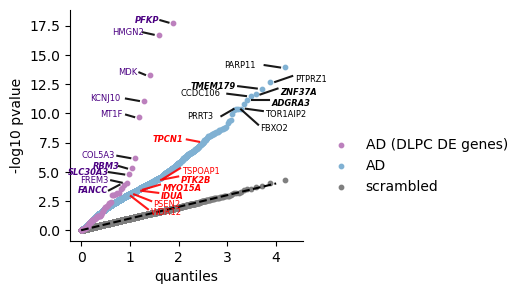

In [339]:
x3, y3 = get_qqplot(scrambled_ad_pvals, scrambled_ad_pvals.index, genes_df, ensembl=True)

x, y = get_qqplot(ad_pvals, ad_pvals.index.difference(pd.Index(genes_df.loc[genes_df.gene_name.isin(ad_dlpc_genes)].gene_id)), genes_df, ensembl=True)
x2, y2 = get_qqplot(ad_pvals, ad_dlpc_genes, genes_df)

a = sorted(y2)[-10:][::-1]
b = x2[:10:-1]

a_ = sorted(y)[-10:][::-1]
b_ = x[:10:-1]


fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(x2, y2, label='AD (DLPC DE genes)', c='#bc80bd', zorder=2, s=10)

plt.scatter(x, y, label='AD', c='#80b1d3', s=10)
plt.scatter(x3, y3, label='scrambled', c='tab:gray', s=10)
plt.plot([0, 4], [0, 4], linestyle='--', c='black')
ax.set_xlabel('quantiles')
ax.set_ylabel('-log10 pval')
ax.legend(frameon=False, bbox_to_anchor = (1.05, 0.5))
ax.spines[['top', 'right']].set_visible(False)
# plt.show()

for i in range(len(a)):
    gene = top_10[i]
    c = (len(gene)*0.15)+0.2

    gene_ = top_10_[i]
    c_ = (len(gene_)*0.15)+0.2
    if i >= 9:
        e = i*0.075
    # elif i >= 6:
    #     e = i*0.1
    else:
        e = 0


    if top_10_ensembl[i] in ir_genes:
        ax.text(b[i]-c, a[i]-e, gene, size=6, c='indigo', fontweight='bold', fontstyle='italic')
    else:
        ax.text(b[i]-c, a[i]-e, gene, size=6, c='indigo')
    ax.plot([b[i]-(c/3), b[i]-0.1], [a[i]+0.2-e, a[i]], c='black', alpha=0.9)



for i in range(len(a_)):
    gene = top_10_[i]
    if gene.startswith('ENSG'):
        continue
    c = (len(gene)*0.2)+0.05
    if i >= 9:
        e = i*0.2
    elif i >= 5:
        e = i*0.1
    else:
        e = 0

    if i >= 10:
        c = (len(gene)*0.25)+0.1
    if i%2 == 0:
        
        if i < 10:
            if top_10_ensembl_[i] in ir_genes:
                ax.text(b_[i]-c, a_[i]-e, gene, size=6, fontweight='bold', fontstyle='italic')
            else:
                ax.text(b_[i]-c, a_[i]-e, gene, size=6)
            ax.plot([b_[i]-(c/3), b_[i]-0.1], [a_[i]+0.2-e, a_[i]], c='black', alpha=0.9)
        else:
            if top_10_ensembl_[i] in ir_genes:
                ax.text(b_[i]-c, a[i]-e+0.6, gene, size=6, fontweight='bold', fontstyle='italic')
            else:
                ax.text(b_[i]-c, a[i]-e+0.6, gene, size=6)
            ax.plot([b_[i]-(c/2), b_[i]-0.1], [a_[i]+0.8-e, a_[i]], c='black', alpha=0.9)
    else:
        if top_10_ensembl_[i] in ir_genes:
            ax.text(b_[i]+0.5, a_[i]-e, gene, size=6, fontweight='bold', fontstyle='italic')
        else:
            ax.text(b_[i]+0.5, a_[i]-e, gene, size=6)
        ax.plot([b_[i]+0.1, b_[i]+0.45], [a_[i], a_[i]+0.5-e], c='black', alpha=0.9)

a_ = np.array(y[::-1])[y_idx]
b_ = np.array(x[::-1])[y_idx]



for i in range(len(a_)):
    gene = top_ad[i]
    if gene.startswith('ENSG'):
        continue
    c = (len(gene)*0.2)+0.05
    if i >= 1:
        e = i*0.7
    else:
        e = 0

    if i >= 10:
        c = (len(gene)*0.25)+0.1
    if i == 0:
        
        if i < 10:
            if top_ad_ensembl[i] in ir_genes:
                ax.text(b_[i]-c, a_[i]-e, gene, size=6, c='red', fontweight='bold', fontstyle='italic')
            else:
                ax.text(b_[i]-c, a_[i]-e, gene, size=6, c='red')
            ax.plot([b_[i]-(c/3), b_[i]-0.1], [a_[i]+0.2-e, a_[i]], c='red', alpha=0.9)

    else:
        if top_ad_ensembl[i] in ir_genes:
            ax.text(b_[i]+0.5, a_[1]+1.1-e, gene, size=6, c='red', fontweight='bold', fontstyle='italic')
        else:
            ax.text(b_[i]+0.5, a_[1]+1.1-e, gene, size=6, c='red')
        ax.plot([b_[i]+0.1, b_[i]+0.45], [a_[i], a_[1]+1.6-e], c='red', alpha=0.9)


ax.set_xlabel('quantiles')
ax.set_ylabel('-log10 pvalue')

plt.savefig('../code/scratch_figures/figure5/qqplot_ad_final.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/qqplot_ad_final.png', bbox_inches='tight', dpi=500)

In [151]:
'ENSG00000075407' in top_10_ensembl_

True

In [154]:
ad_boxplot.gene.unique()

array(['ENSG00000148123', 'ENSG00000176155', 'ENSG00000205209', ...,
       'ENSG00000087206', 'ENSG00000159592', 'ENSG00000090054'],
      dtype=object)

In [155]:
'ENSG00000075407' in ad_boxplot.gene.unique()

True

In [159]:
'ENSG00000075407' in introns_bed.gene.unique()

False

Text(0, 0.5, 'Intron retention\nfactor loadings')

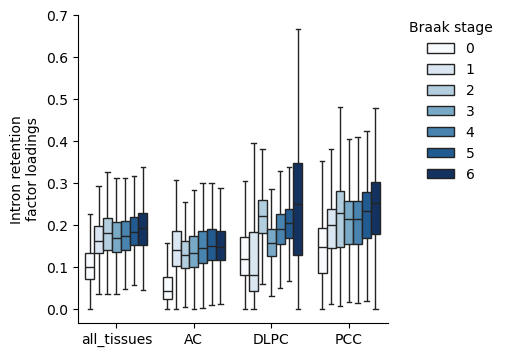

In [227]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(data = ad_boxplot.loc[(ad_boxplot.FDR <= 5e-2)], x = 'tissue', y = 'loadings', hue = 'braaksc', showfliers=False,
           palette='Blues', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False, title='Braak stage')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('Intron retention\nfactor loadings')

# plt.savefig('../code/scratch_figures/figure5/IR_braaksc_correlation.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure5/IR_braaksc_correlation.png', bbox_inches='tight', dpi=500)

In [228]:
ad_boxplot.loc[(ad_boxplot.FDR <= 5e-2)]

,gene,isoform,loadings,braaksc,FDR,tissue,beta,ad_beta,zscore
0,ENSG00000148123,ENSG00000148123.isoform_2,0.452594,0,0.044029,all_tissues,-0.011765,-1.146892,-2.205492
1,ENSG00000176155,ENSG00000176155.isoform_1,0.074671,0,0.000211,all_tissues,0.012402,2.335530,2.752517
2,ENSG00000205209,ENSG00000205209.isoform_1,0.169847,0,0.023469,all_tissues,0.005665,1.590025,1.382420
3,ENSG00000101935,ENSG00000101935.isoform_2,0.242265,0,0.004806,all_tissues,-0.010587,-2.557261,-3.249018
4,ENSG00000182054,ENSG00000182054.isoform_2,0.036553,0,0.031578,all_tissues,0.005124,2.974948,2.314633
...,...,...,...,...,...,...,...,...,...
55211,ENSG00000168970,ENSG00000168970.isoform_3,0.347225,6,0.022094,PCC,0.004413,1.669002,1.130089
55212,ENSG00000101203,ENSG00000101203.isoform_1,0.061175,6,0.009388,PCC,0.013430,1.542742,2.648980
55213,ENSG00000087206,ENSG00000087206.isoform_3,0.257225,6,0.036959,PCC,0.003022,1.537936,0.743802
55214,ENSG00000159592,ENSG00000159592.isoform_3,0.241300,6,0.014187,PCC,0.007408,2.368337,2.444691


Text(0, 0.5, 'Intron retention\nfactor loadings')

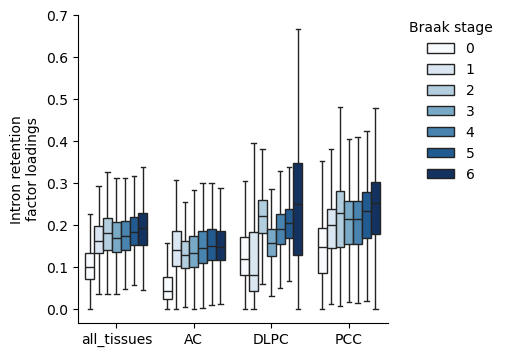

In [231]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(data = ad_boxplot.loc[(ad_boxplot.FDR <= 5e-2)], x = 'tissue', y = 'loadings', hue = 'braaksc', showfliers=False,
           palette='Blues', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False, title='Braak stage')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('Intron retention\nfactor loadings')

# plt.savefig('../code/scratch_figures/figure5/IR_braaksc_correlation.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure5/IR_braaksc_correlation.png', bbox_inches='tight', dpi=500)

In [242]:
introns_bed = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_1e3.bed.gz', sep='\t')
introns_bed2 = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_1e2.bed.gz', sep='\t')
introns_bed3 = pd.read_csv('../code/ebpmf_models/gao_models/tables/AD_IR_plots_5e2.bed.gz', sep='\t')

introns_bed4 = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_AD_IR_plots_1e3.bed.gz', sep='\t')
introns_bed5 = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_AD_IR_plots_1e2.bed.gz', sep='\t')
introns_bed6 = pd.read_csv('../code/ebpmf_models/gao_models/tables/second_AD_IR_plots_5e2.bed.gz', sep='\t')


introns_bed = pd.concat([introns_bed, introns_bed2, introns_bed3, introns_bed4, introns_bed5, introns_bed6], axis=0)
introns_bed.index = range(introns_bed.shape[0])

coverage_zmean_dlpc = introns_bed.groupby(['gene'])[[f'braaks_{str(i)}_zloadings.DLPC' for i in range(7)]].mean()
coverage_zmean_pcc = introns_bed.groupby(['gene'])[[f'braaks_{str(i)}_zloadings.PCC' for i in range(7)]].mean()

141
559
92
114
18
341
403
134


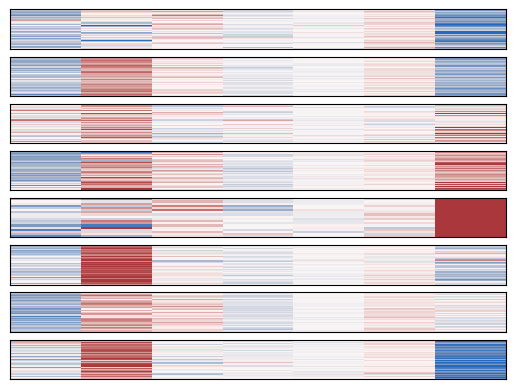

In [240]:
KM = KMeans(random_state=0).fit(coverage_zmean)
km_labels = KM.labels_
fig, axes = plt.subplots(nrows=8)#, gridspec_kw={'height_ratios':height_ratios, 'hspace':0.05})
for i in range(8):
    print(sum(KM.labels_ == i))
    slice_zmean = coverage_zmean.loc[KM.labels_ == i]
    sns.heatmap(slice_zmean, ax=axes[i], cmap='vlag', vmin=-1, vmax=1, cbar=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(True)

In [243]:
coverage_zmean_dlpc

,braaks_0_zloadings.DLPC,braaks_1_zloadings.DLPC,braaks_2_zloadings.DLPC,braaks_3_zloadings.DLPC,braaks_4_zloadings.DLPC,braaks_5_zloadings.DLPC,braaks_6_zloadings.DLPC
gene,,,,,,,
ENSG00000000419,-0.410512,0.154328,0.133490,-0.194465,-0.097111,0.261687,-0.123775
ENSG00000000460,0.116091,0.313901,-0.091988,-0.069330,0.014559,0.018587,-0.228776
ENSG00000001497,-0.099805,0.226563,-0.037661,-0.088312,-0.111842,0.206540,0.468757
ENSG00000002746,-0.564984,0.509837,0.235803,-0.206243,-0.075643,0.175100,-0.218800
ENSG00000002822,-0.342765,0.370427,0.156887,-0.117609,-0.093709,0.174255,-0.659179
...,...,...,...,...,...,...,...
ENSG00000278259,0.024272,0.497330,-0.051132,-0.062101,-0.038565,0.059394,-0.177175
ENSG00000278535,-0.494486,0.322663,0.130753,-0.269962,-0.054031,0.247545,-0.278824
ENSG00000284770,-0.534702,0.249590,0.160455,-0.214558,-0.016668,0.148868,-0.089263


In [293]:
plt.scatter(np.array(coverage_zmean_pcc['ad_zloadings.PCC']), np.array(coverage_zmean_dlpc['ad_zloadings.DLPC']))

KeyError: 'ad_zloadings.PCC'

In [254]:
spearmanr(np.array(coverage_zmean_pcc['braaks_1_zloadings.PCC']), np.array(coverage_zmean_dlpc['braaks_1_zloadings.DLPC']))

SignificanceResult(statistic=0.16681502639719237, pvalue=1.0305280287498675e-12)

(array([  2.,   3.,  15.,  36., 138., 455., 665., 408.,  66.,  14.]),
 array([-0.36394099, -0.28844114, -0.21294129, -0.13744144, -0.06194159,
         0.01355826,  0.08905811,  0.16455796,  0.24005781,  0.31555766,
         0.39105751]),
 <BarContainer object of 10 artists>)

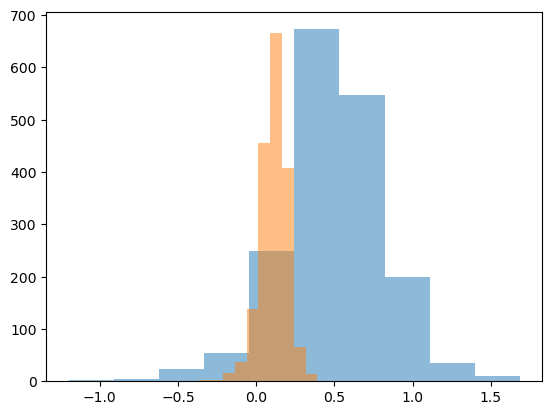

In [263]:
plt.hist(np.array(coverage_zmean_dlpc['braaks_1_zloadings.DLPC']), alpha=0.5)
plt.hist(np.array(coverage_zmean_dlpc['braaks_5_zloadings.DLPC']), alpha=0.5)

(array([  6.,  15.,  64., 258., 682., 547., 181.,  38.,  10.,   1.]),
 array([-1.10626359, -0.82000439, -0.53374518, -0.24748597,  0.03877323,
         0.32503244,  0.61129165,  0.89755085,  1.18381006,  1.47006927,
         1.75632847]),
 <BarContainer object of 10 artists>)

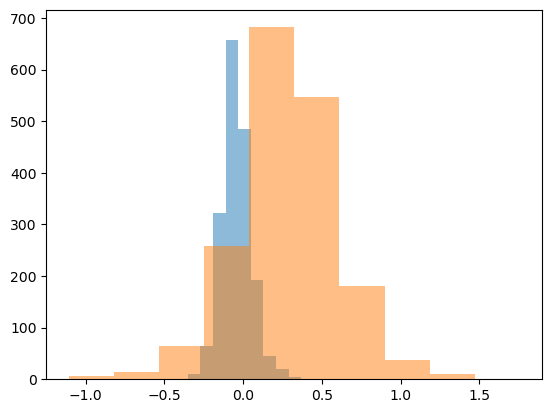

In [281]:
plt.hist(np.array(coverage_zmean_pcc['braaks_1_zloadings.PCC']), alpha=0.5)
plt.hist(np.array(coverage_zmean_pcc['braaks_6_zloadings.PCC']), alpha=0.5)

In [265]:

isoforms = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf_5.merged_isoforms.exons.sorted.bed.gz', sep='\t',
                      names = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand', 'factor', 'exon'])

gencode = pd.read_csv('../code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz', sep='\t', 
                     names = ['chrom', 'start', 'end', 'gene', 'transcript', 'strand', 'exon', 'score', 'gencode_annot', 
                              'ensembl', 'mane', 'appris', 'annotation'])

ad_boxplot = pd.read_csv('../code/intron_retention.second_AD_dataframe.tab.gz', sep='\t')

EL = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf5_EL.tab.gz', sep='\t', index_col=3)


samples = EL.columns[5:]

metadata = pd.read_csv('../code/gao_data/metadata/merged_metadata.tab.gz', sep='\t', index_col=0)

X = EL[EL.columns[5:]]

metadata_test = metadata.loc[EL.columns.intersection(metadata.index)]


column_names = ['chrom', 'start', 'end', 'gene', 'isoform']
braak_columns = []
for i in range(7):
    braaks_col = f'braaks_{str(i)}_loadings'
    braak_columns.append(braaks_col)
    braaks_col = f'braaks_{str(i)}_zloadings'
    braak_columns.append(braaks_col)

braak_columns.extend(['braaks_low_loadings',
                       'braaks_low_zloadings',
                       'braaks_high_loadings',
                       'braaks_high_zloadings'])

braak_ac_columns = [x + '.AC' for x in braak_columns]
braak_dlpc_columns = [x + '.DLPC' for x in braak_columns]
braak_pcc_columns = [x + '.PCC' for x in braak_columns]

ad_columns = ['ctrl_loadings',
              'ctrl_zloadings',
              'ad_loadings',
              'ad_zloadings']

ad_ac_columns = [x + '.AC' for x in ad_columns]
ad_dlpc_columns = [x + '.DLPC' for x in ad_columns]
ad_pcc_columns = [x + '.PCC' for x in ad_columns]

column_names += braak_columns + braak_ac_columns + braak_dlpc_columns + braak_pcc_columns + ad_columns + ad_ac_columns + ad_dlpc_columns + ad_pcc_columns
    



In [266]:
metadata

,individualID,tissue,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,...,libraryPreparationMethod,isStranded,readStrandOrigin,runType,readLength,notes,AD,condition,tissue_id,batch
specimenID,,,,,,,,,,,,,,,,,,,,,
510_120515,R9976232,dorsolateral prefrontal cortex,21183160,ROS,0.0,16.0,1.0,2.0,33.0,89.338809034907598,...,NaN,True,NaN,pairedEnd,101,data contribution batch 1,ad,AD,DLPC,batch1
207_120424,R9936070,dorsolateral prefrontal cortex,2899847,MAP,1.0,14.0,1.0,2.0,33.0,73.489390828199859,...,NaN,True,NaN,pairedEnd,101,data contribution batch 1,non_ad,MCI,DLPC,batch1
81_120417,R9907075,dorsolateral prefrontal cortex,11616707,ROS,1.0,19.0,1.0,2.0,34.0,72.933607118412041,...,NaN,True,NaN,pairedEnd,101,data contribution batch 1,ad,AD,DLPC,batch1
649_120529,R9905342,dorsolateral prefrontal cortex,21293107,ROS,0.0,21.0,1.0,2.0,34.0,80.558521560574945,...,NaN,True,NaN,pairedEnd,101,data contribution batch 1,ad,AD,DLPC,batch1
487_120515,R9904978,dorsolateral prefrontal cortex,51668135,MAP,1.0,22.0,1.0,2.0,33.0,72.093086926762496,...,NaN,True,NaN,pairedEnd,101,data contribution batch 1,non_ad,no condition,DLPC,batch1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RISK_364,R7645936,dorsolateral prefrontal cortex,21001195,ROS,0.0,20.0,1.0,2.0,33.0,90+,...,TruSeq,True,reverse,pairedEnd,150,data contribution batch 3,non_ad,MCI,DLPC,batch3
RISK_365,R9085798,dorsolateral prefrontal cortex,20380831,ROS,0.0,18.0,1.0,2.0,23.0,90+,...,TruSeq,True,reverse,pairedEnd,150,data contribution batch 3,ad,AD,DLPC,batch3
RISK_366,R6912665,dorsolateral prefrontal cortex,21171080,ROS,0.0,21.0,1.0,2.0,33.0,82.683093771389466,...,TruSeq,True,reverse,pairedEnd,150,data contribution batch 3,ad,AD,DLPC,batch3


In [290]:
introns_bed['ad_zloadings.DLPC'].mean()

0.14994490325488177

In [289]:
introns_bed['ctrl_zloadings.DLPC'].mean()

-0.09554476906023522

In [291]:
introns_bed['braaks_high_zloadings.DLPC'].mean()

0.09580650342848271

In [292]:
introns_bed['braaks_low_zloadings.DLPC'].mean()

0.13608915140332312

In [294]:
coverage_zmean_ad = introns_bed.groupby(['gene'])[['ctrl_zloadings.DLPC', 'ad_zloadings.DLPC', 'ctrl_zloadings.PCC', 'ad_zloadings.PCC']].mean()


In [299]:
coverage_zmean_ad['ctrl_zloadings.PCC'].mean()

-0.10106203400485031

In [300]:
coverage_zmean_ad['ad_zloadings.PCC'].mean()

0.15657906024694898

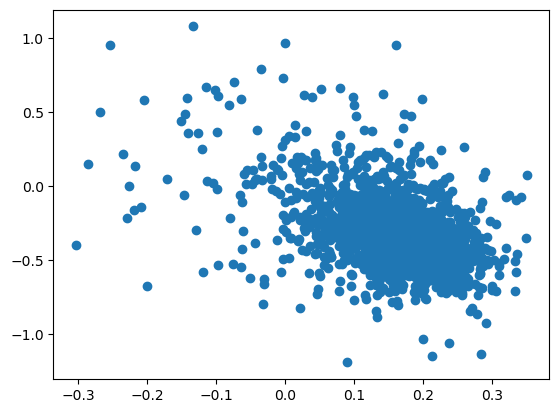

In [307]:
plt.scatter(np.array(coverage_zmean_ad['ad_zloadings.DLPC']), np.array(coverage_zmean_dlpc['braaks_0_zloadings.DLPC']))

In [308]:
coverage_zmean_dlpc

,braaks_0_zloadings.DLPC,braaks_1_zloadings.DLPC,braaks_2_zloadings.DLPC,braaks_3_zloadings.DLPC,braaks_4_zloadings.DLPC,braaks_5_zloadings.DLPC,braaks_6_zloadings.DLPC
gene,,,,,,,
ENSG00000000419,-0.410512,0.154328,0.133490,-0.194465,-0.097111,0.261687,-0.123775
ENSG00000000460,0.116091,0.313901,-0.091988,-0.069330,0.014559,0.018587,-0.228776
ENSG00000001497,-0.099805,0.226563,-0.037661,-0.088312,-0.111842,0.206540,0.468757
ENSG00000002746,-0.564984,0.509837,0.235803,-0.206243,-0.075643,0.175100,-0.218800
ENSG00000002822,-0.342765,0.370427,0.156887,-0.117609,-0.093709,0.174255,-0.659179
...,...,...,...,...,...,...,...
ENSG00000278259,0.024272,0.497330,-0.051132,-0.062101,-0.038565,0.059394,-0.177175
ENSG00000278535,-0.494486,0.322663,0.130753,-0.269962,-0.054031,0.247545,-0.278824
ENSG00000284770,-0.534702,0.249590,0.160455,-0.214558,-0.016668,0.148868,-0.089263


In [309]:
ad_boxplot.groupby

,gene,isoform,loadings,braaksc,FDR,tissue,beta,ad_beta,zscore
0,ENSG00000042286,ENSG00000042286.isoform_2,0.099488,0,1.158530e-02,all_tissues,0.002970,0.577127,0.468111
1,ENSG00000167986,ENSG00000167986.isoform_3,0.024382,0,3.235957e-02,all_tissues,0.002522,3.078103,1.656552
2,ENSG00000067057,ENSG00000067057.isoform_4,0.095612,0,2.666678e-14,all_tissues,0.021046,2.734225,4.868866
3,ENSG00000136319,ENSG00000136319.isoform_2,0.087865,0,6.944439e-03,all_tissues,0.009670,1.857966,2.521454
4,ENSG00000070159,ENSG00000070159.isoform_3,0.106706,0,2.598360e-02,all_tissues,0.004289,1.127678,0.656103
...,...,...,...,...,...,...,...,...,...
23459,ENSG00000215045,ENSG00000215045.isoform_3,0.059100,6,1.500746e-03,PCC,0.004511,1.044605,0.744882
23460,ENSG00000176769,ENSG00000176769.isoform_1,0.468875,6,2.852343e-02,PCC,0.009687,1.205040,1.825169
23461,ENSG00000268182,ENSG00000268182.isoform_3,0.339650,6,1.489646e-02,PCC,0.010915,1.100152,1.784134
23462,ENSG00000172845,ENSG00000172845.isoform_4,0.231825,6,2.214949e-02,PCC,0.003143,0.625114,0.517064


In [318]:
for i in range(7):
    print(metadata_test.loc[(metadata_test.tissue_id == 'AC') & (metadata_test.braaksc == i)].shape[0])

7
48
50
167
215
137
7


In [319]:
for i in range(7):
    print(metadata_test.loc[(metadata_test.tissue_id == 'DLPC') & (metadata_test.braaksc == i)].shape[0])

3
4
11
23
45
31
1


In [320]:
for i in range(7):
    print(metadata_test.loc[(metadata_test.tissue_id == 'PCC') & (metadata_test.braaksc == i)].shape[0])

7
36
43
134
138
82
4


In [329]:
def select_color_finer(z, colores):
    if z <= -0.5:
        out_color = colores[0]
    elif z <= -0.2:
        out_color = colores[1]
    elif z <= -0.1:
        out_color = colores[2]
    elif z <= -0.01:
        out_color = colores[3]
    elif z <= 0:
        out_color = colores[4]
    elif z >= 0.5:
        out_color = colores[9]
    elif z >= 0.2:
        out_color = colores[8]
    elif z >= 0.1:
        out_color = colores[7]
    elif z >= 0.01:
        out_color = colores[6]
    elif z > 0.0:
        out_color = colores[5]
    else:
        out_color = 'gray'
    return out_color

def add_vertical_colorbar_to_ax_finer(ax, colores):
    # Create a custom colormap and norm for the colorbar
    cmap = ListedColormap(colores)
    bounds = [-1, -0.5, -0.2, -0.1, -0.01, 0, 0.01, 0.1, 0.2, 0.5, 1]
    norm = BoundaryNorm(bounds, cmap.N)

    # Add the colorbar to the right of the ax, vertically
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax, orientation='vertical', boundaries=bounds, pad=0.1
    )
    cbar.set_label('Z score')



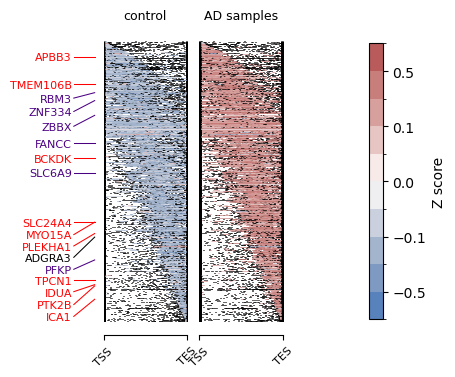

In [340]:
pos = 0

fig, axes = plt.subplots(ncols = 4, figsize=(4, 4), gridspec_kw={'width_ratios': [0.25, 1, 1, 1], 'wspace':0.05})

colores = sns.color_palette("vlag", 10)
counts_tag = 0
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(1, 3):
        axes[i].plot([-0.02, 0], [pos, pos], c='black', linewidth=0.5)
        axes[i].plot([1, 1.02], [pos, pos], c='black', linewidth=0.5)
        



    axes[0].spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    if gene in genes_to_highlight:
        gene_name = genes_df.loc[genes_df.gene_id == gene].gene_name.iloc[0]

        if gene in ad_gene_ru_id:
            tag_color = 'red'
        elif gene in DEGenes:
            tag_color = 'indigo'
        else:
            tag_color = 'black'

        stack = stackings[counts_tag]
        
        # if stack > 0:
        #     axes[0].plot([-0.2, -0.05], [pos, pos], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.4, -0.3], [pos-stack, pos-stack], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.3, -0.2], [pos-stack, pos], c=tag_color, linewidth=0.75)
        #     axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        # else:
        axes[0].plot([-0.4, -0.05], [pos-stack, pos], c=tag_color, linewidth=0.75)
        axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        counts_tag += 1
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(1, 3):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black', linewidth=0.5)


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i, col_name in enumerate(['ctrl_zloadings.PCC', 'ad_zloadings.PCC']):
            col_score = row[col_name]
            axes[i+1].plot([int_start, int_end], [pos, pos], linewidth=0.5, c=select_color_finer(col_score, colores))
    pos -= 1

for i, col_name in enumerate(['control', 'AD samples']):
    axes[i+1].set_yticks([])
    axes[i+1].set_title(col_name, size=9)

for i in range(1, 3):
    axes[i].spines[['top', 'left', 'right']].set_visible(False)

    # axes[i].set_xlim((-0.075, 1.075))
    axes[i].set_xticks((-0.02, 1.02))
    axes[i].set_xticklabels(['TSS', 'TES'], size=8, rotation=45)
    axes[i].spines['bottom'].set_bounds(-0.02, 1.02)
    
# axes[0].set_ylim((-1891.05, 90.05000000000001))
axes[0].set_ylim(axes[1].get_ylim())

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[3].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[3].set_xticks([])
axes[3].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax_finer(axes[3], colores)

plt.savefig('../code/scratch_figures/figure5/IR_ctrl_v_AD.PCC.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_ctrl_v_AD.PCC.png', bbox_inches='tight', dpi=500)

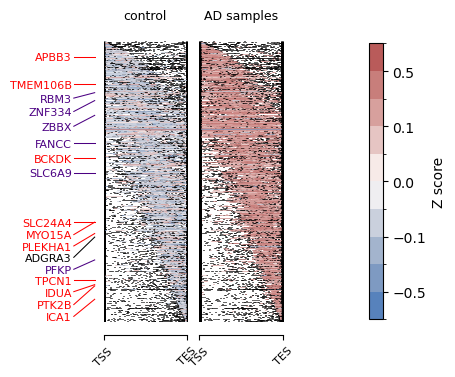

In [341]:
pos = 0

fig, axes = plt.subplots(ncols = 4, figsize=(4, 4), gridspec_kw={'width_ratios': [0.25, 1, 1, 1], 'wspace':0.05})

colores = sns.color_palette("vlag", 10)
counts_tag = 0
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(1, 3):
        axes[i].plot([-0.02, 0], [pos, pos], c='black', linewidth=0.5)
        axes[i].plot([1, 1.02], [pos, pos], c='black', linewidth=0.5)
        



    axes[0].spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    if gene in genes_to_highlight:
        gene_name = genes_df.loc[genes_df.gene_id == gene].gene_name.iloc[0]

        if gene in ad_gene_ru_id:
            tag_color = 'red'
        elif gene in DEGenes:
            tag_color = 'indigo'
        else:
            tag_color = 'black'

        stack = stackings[counts_tag]
        
        # if stack > 0:
        #     axes[0].plot([-0.2, -0.05], [pos, pos], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.4, -0.3], [pos-stack, pos-stack], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.3, -0.2], [pos-stack, pos], c=tag_color, linewidth=0.75)
        #     axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        # else:
        axes[0].plot([-0.4, -0.05], [pos-stack, pos], c=tag_color, linewidth=0.75)
        axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        counts_tag += 1
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(1, 3):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black', linewidth=0.5)


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i, col_name in enumerate(['ctrl_zloadings.DLPC', 'ad_zloadings.DLPC']):
            col_score = row[col_name]
            axes[i+1].plot([int_start, int_end], [pos, pos], linewidth=0.5, c=select_color_finer(col_score, colores))
    pos -= 1

for i, col_name in enumerate(['control', 'AD samples']):
    axes[i+1].set_yticks([])
    axes[i+1].set_title(col_name, size=9)

for i in range(1, 3):
    axes[i].spines[['top', 'left', 'right']].set_visible(False)

    # axes[i].set_xlim((-0.075, 1.075))
    axes[i].set_xticks((-0.02, 1.02))
    axes[i].set_xticklabels(['TSS', 'TES'], size=8, rotation=45)
    axes[i].spines['bottom'].set_bounds(-0.02, 1.02)
    
# axes[0].set_ylim((-1891.05, 90.05000000000001))
axes[0].set_ylim(axes[1].get_ylim())

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[3].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[3].set_xticks([])
axes[3].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax_finer(axes[3], colores)

plt.savefig('../code/scratch_figures/figure5/IR_ctrl_v_AD.DLPC.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_ctrl_v_AD.DLPC.png', bbox_inches='tight', dpi=500)

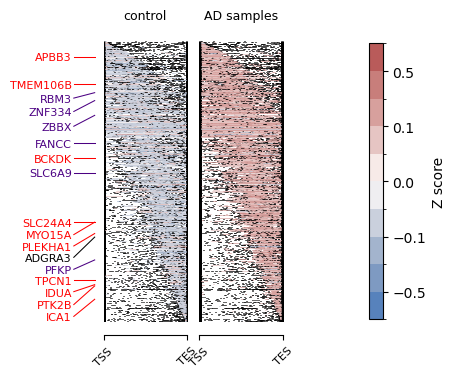

In [342]:
pos = 0

fig, axes = plt.subplots(ncols = 4, figsize=(4, 4), gridspec_kw={'width_ratios': [0.25, 1, 1, 1], 'wspace':0.05})

colores = sns.color_palette("vlag", 10)
counts_tag = 0
for idx, row in order_df.sort_values('position').iterrows():
    gene = row.gene
    strand = row.strand
    gencode_bed, gencode_full_gene = get_gencode_bed(gencode, gene)
    gencode_bed = gencode_bed.to_dataframe()
    start_ = gencode_bed.end.iloc[0]
    end_ = gencode_bed.start.iloc[-1]


    for i in range(1, 3):
        axes[i].plot([-0.02, 0], [pos, pos], c='black', linewidth=0.5)
        axes[i].plot([1, 1.02], [pos, pos], c='black', linewidth=0.5)
        



    axes[0].spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    if gene in genes_to_highlight:
        gene_name = genes_df.loc[genes_df.gene_id == gene].gene_name.iloc[0]

        if gene in ad_gene_ru_id:
            tag_color = 'red'
        elif gene in DEGenes:
            tag_color = 'indigo'
        else:
            tag_color = 'black'

        stack = stackings[counts_tag]
        
        # if stack > 0:
        #     axes[0].plot([-0.2, -0.05], [pos, pos], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.4, -0.3], [pos-stack, pos-stack], c=tag_color, linewidth=0.75)
        #     axes[0].plot([-0.3, -0.2], [pos-stack, pos], c=tag_color, linewidth=0.75)
        #     axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        # else:
        axes[0].plot([-0.4, -0.05], [pos-stack, pos], c=tag_color, linewidth=0.75)
        axes[0].text(-0.43, pos-25-stack, gene_name, c=tag_color, size=8, horizontalalignment='right')
        counts_tag += 1
        
    if gencode_bed.shape[0] >= 3:

        for idx, row in gencode_bed.iloc[1:-1].iterrows():
            ex_start = (row.start - start_)/(end_ - start_)
            ex_end = (row.end - start_)/(end_ - start_)
            if strand == '-':
                ex_start = 1-ex_start
                ex_end = 1-ex_end
            for i in range(1, 3):
                axes[i].plot([ex_start, ex_end], [pos, pos], c='black', linewidth=0.5)


    for idx, row in introns_bed.loc[introns_bed.gene == gene].iterrows():
        int_start = (row.start - start_)/(end_ - start_)
        int_end = (row.end - start_)/(end_ - start_)
        if strand == '-':
            int_start = 1 - int_start
            int_end = 1 - int_end
        for i, col_name in enumerate(['ctrl_zloadings', 'ad_zloadings']):
            col_score = row[col_name]
            axes[i+1].plot([int_start, int_end], [pos, pos], linewidth=0.5, c=select_color_finer(col_score, colores))
    pos -= 1

for i, col_name in enumerate(['control', 'AD samples']):
    axes[i+1].set_yticks([])
    axes[i+1].set_title(col_name, size=9)

for i in range(1, 3):
    axes[i].spines[['top', 'left', 'right']].set_visible(False)

    # axes[i].set_xlim((-0.075, 1.075))
    axes[i].set_xticks((-0.02, 1.02))
    axes[i].set_xticklabels(['TSS', 'TES'], size=8, rotation=45)
    axes[i].spines['bottom'].set_bounds(-0.02, 1.02)
    
# axes[0].set_ylim((-1891.05, 90.05000000000001))
axes[0].set_ylim(axes[1].get_ylim())

cmap = mcolors.ListedColormap(colores)
norm = mcolors.BoundaryNorm(np.arange(len(colores)+1)-0.5, len(colores))

# Create a scatter plot

axes[3].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
axes[3].set_xticks([])
axes[3].set_yticks([])
# axes[7].set_ylim([pos, 0])

# Add a colorbar
add_vertical_colorbar_to_ax_finer(axes[3], colores)

plt.savefig('../code/scratch_figures/figure5/IR_ctrl_v_AD.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/IR_ctrl_v_AD.png', bbox_inches='tight', dpi=500)

In [344]:
metadata.tissue.unique()

array(['dorsolateral prefrontal cortex', 'Head of caudate nucleus',
       'posterior cingulate cortex'], dtype=object)